In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from math import sqrt

import DataAid
import Neros

In [21]:
# Collect the data from each of the folders
sparcGalaxies = DataAid.GetGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = DataAid.GetGalaxyData("data/XueSofue/")
# Get the galaxies we want from each source
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

# chi squared function
def chiSquared(observed, expected, error):
    chiSquared = 0
    
    for i in range(len(observed)):
        chiSquared = chiSquared + (((observed[i] - expected[i])**2) / (error[i]**2))
        
    return chiSquared / len(observed)

# Fit function
def simple(independents, alpha, vLumFreeParam):
    # Parse out data for the galaxy
    rad,vLum = independents
    # Apply the vLum free param to the data
    vLum = vLum*vLumFreeParam
    # Calc vLCM with alpha free param
    vLcm = Neros.vLcm(rad, MW_vLum_interp_func(rad), vLum)
    # Calc and return vNeros
    return Neros.vNeros(vLum, vLcm, alpha)

## Create the Milky Way interpolation function

In [22]:
MW_rad = MWXueSofue[:,0]
MW_vLum = MWXueSofue[:,1]
# Interpolation function
MW_vLum_interp_func = interp1d(MW_rad, MW_vLum, kind='cubic')

## Running VNeros on every galaxy
We calculate vNeros for each galaxy and then plot the ratio between vNeros and the galaxy's vObs

galaxyName is: CamB_rotmod
chiSquare is: 0.9053971777195048
fittedAlpha is: 35670.64413299052, 
fittedVLumFreeParam is: 0.5918425195571565
galaxyName is: D512-2_rotmod
chiSquare is: 0.06253174468829198
fittedAlpha is: 1335.4146463496697, 
fittedVLumFreeParam is: 1.4891638518376622
galaxyName is: D564-8_rotmod
chiSquare is: 0.14978569628548355
fittedAlpha is: 19663.615664195648, 
fittedVLumFreeParam is: 1.2321673157447217
galaxyName is: D631-7_rotmod
chiSquare is: 2.8239207137115345
fittedAlpha is: 6613.921279675725, 
fittedVLumFreeParam is: 1.036617212706322
galaxyName is: DDO064_rotmod
chiSquare is: 0.24103962015485994
fittedAlpha is: 152.3319335933504, 
fittedVLumFreeParam is: 1.6747788154467864
galaxyName is: DDO154_rotmod
chiSquare is: 40.86087611409463
fittedAlpha is: 4185.797545152656, 
fittedVLumFreeParam is: 1.5121341043428884
galaxyName is: DDO161_rotmod
chiSquare is: 2.0351055900076345
fittedAlpha is: 4002.29266990902, 
fittedVLumFreeParam is: 1.0136288722413975
galaxyName is

C:\Users\besk4\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


galaxyName is: F568-3_rotmod
chiSquare is: 1.7850112073394868
fittedAlpha is: 3992.7837922299555, 
fittedVLumFreeParam is: 1.1470822611441227
galaxyName is: F568-V1_rotmod
chiSquare is: 0.2913706248456635
fittedAlpha is: 193.68423391865278, 
fittedVLumFreeParam is: 2.1287202887098715
galaxyName is: F571-8_rotmod
chiSquare is: 6.331452494270059
fittedAlpha is: 1629.379660079349, 
fittedVLumFreeParam is: 0.6173442068786638
galaxyName is: F571-V1_rotmod
chiSquare is: 0.3184060473866323
fittedAlpha is: 3370.974739766397, 
fittedVLumFreeParam is: 1.314414073766764
galaxyName is: F574-1_rotmod
chiSquare is: 2.882563705654088
fittedAlpha is: 4181.564940719275, 
fittedVLumFreeParam is: 1.1060837697336767
galaxyName is: F574-2_rotmod
chiSquare is: 0.017004593617774955
fittedAlpha is: 17349.30447477458, 
fittedVLumFreeParam is: 0.5757249241824436
galaxyName is: F579-V1_rotmod
chiSquare is: 4.2306926171665635
fittedAlpha is: 1991.1684917354144, 
fittedVLumFreeParam is: 1.0994925931119157
galaxyNa

galaxyName is: NGC4559_rotmod
chiSquare is: 3.654445322983581
fittedAlpha is: 279.0541454611949, 
fittedVLumFreeParam is: 0.9993233026613364
galaxyName is: NGC5005_rotmod
chiSquare is: 0.3517649010104305
fittedAlpha is: 99.8418406459743, 
fittedVLumFreeParam is: 0.797763190880298
galaxyName is: NGC5033_rotmod
chiSquare is: 41.4488323463462
fittedAlpha is: 31.27043378134454, 
fittedVLumFreeParam is: 0.8818743943094077
galaxyName is: NGC5055_rotmod
chiSquare is: 1988.2525245817048
fittedAlpha is: 19.28645109578115, 
fittedVLumFreeParam is: 0.7325659592024749
galaxyName is: NGC5371_rotmod
chiSquare is: 8.292284151141667
fittedAlpha is: 36.625419699397845, 
fittedVLumFreeParam is: 0.8356292388505843
galaxyName is: NGC5585_rotmod
chiSquare is: 15.3550937696364
fittedAlpha is: 1443.2860737530812, 
fittedVLumFreeParam is: 0.9300904718172074
galaxyName is: NGC5907_rotmod
chiSquare is: 4.859027424567322
fittedAlpha is: 51.361753504142726, 
fittedVLumFreeParam is: 1.037813476279169
galaxyName is

galaxyName is: UGC06818_rotmod
chiSquare is: 2.521577023944552
fittedAlpha is: 4861.644375159747, 
fittedVLumFreeParam is: 0.9151261642967086
galaxyName is: UGC06917_rotmod
chiSquare is: 1.2973724239633506
fittedAlpha is: 2990.3157567400044, 
fittedVLumFreeParam is: 0.9958592125085368
galaxyName is: UGC06923_rotmod
chiSquare is: 1.054442934709242
fittedAlpha is: 1225.7951756063626, 
fittedVLumFreeParam is: 0.9983217091956221
galaxyName is: UGC06930_rotmod
chiSquare is: 1.564571742479965
fittedAlpha is: 1978.6475976403694, 
fittedVLumFreeParam is: 1.0002707732014655
galaxyName is: UGC06973_rotmod
chiSquare is: 8.47496208103089
fittedAlpha is: 3450.560279625849, 
fittedVLumFreeParam is: 0.47298685638860744
galaxyName is: UGC06983_rotmod
chiSquare is: 1.0115645715292074
fittedAlpha is: 809.5236764088319, 
fittedVLumFreeParam is: 1.3521171460191879
galaxyName is: UGC07089_rotmod
chiSquare is: 0.10608373011809318
fittedAlpha is: 3653.9844645266203, 
fittedVLumFreeParam is: 0.939165983280111

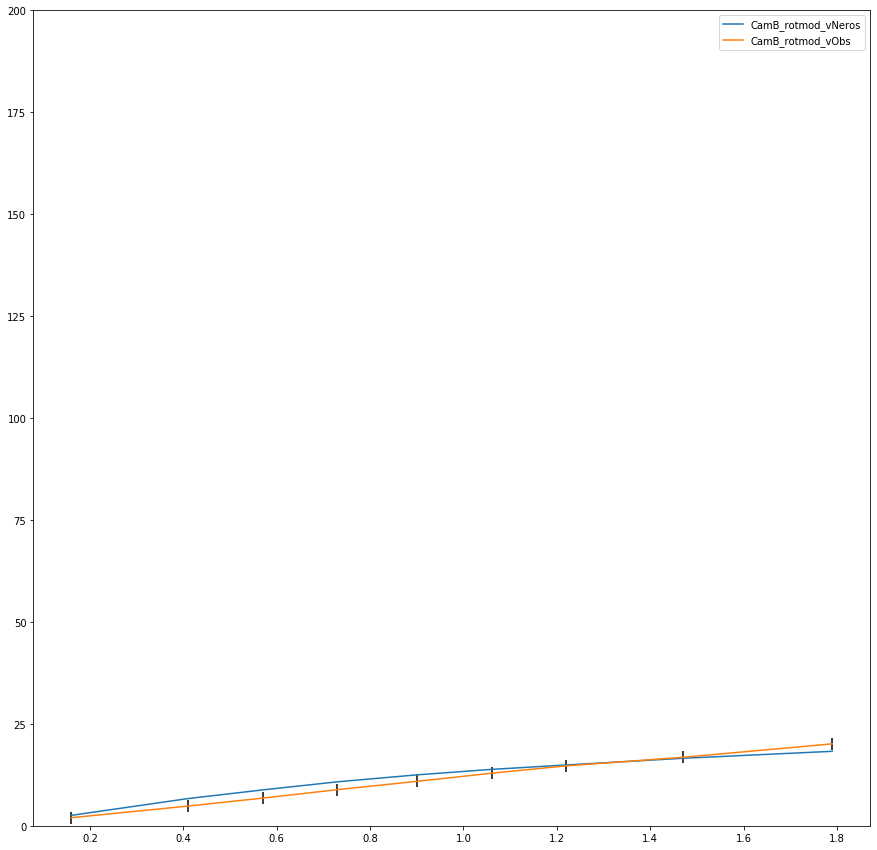

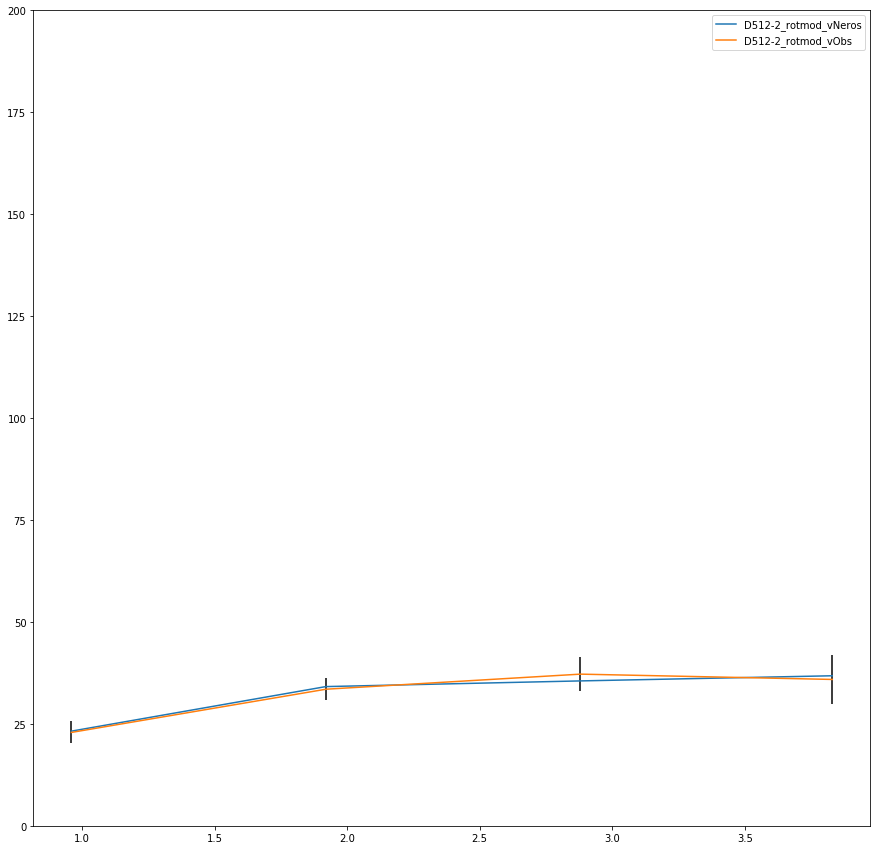

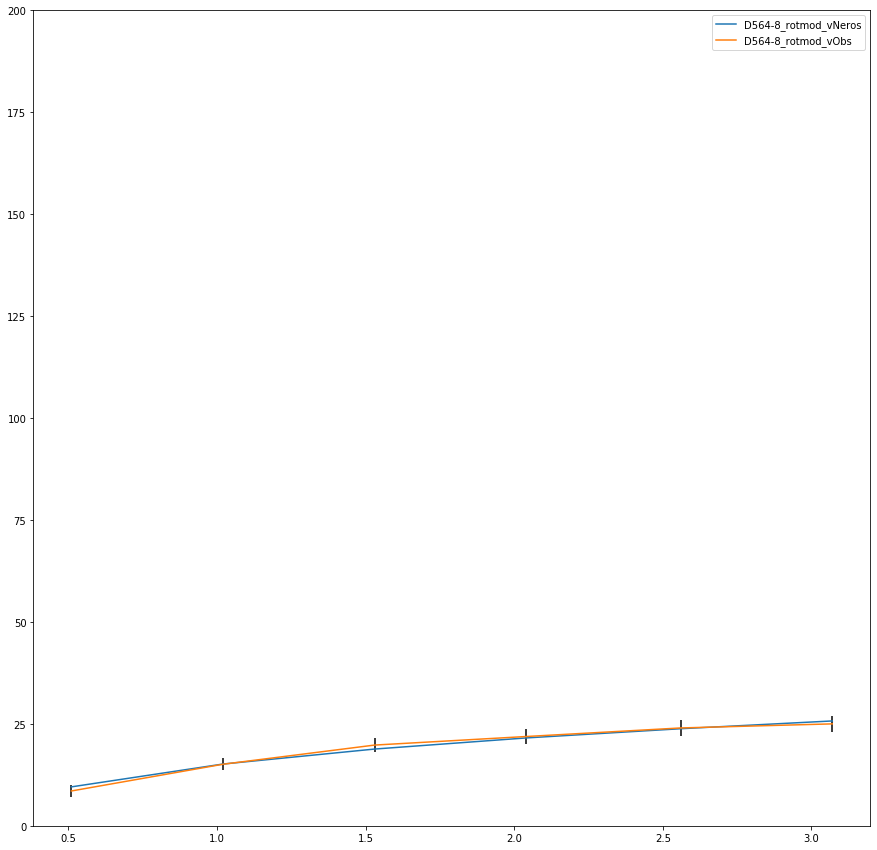

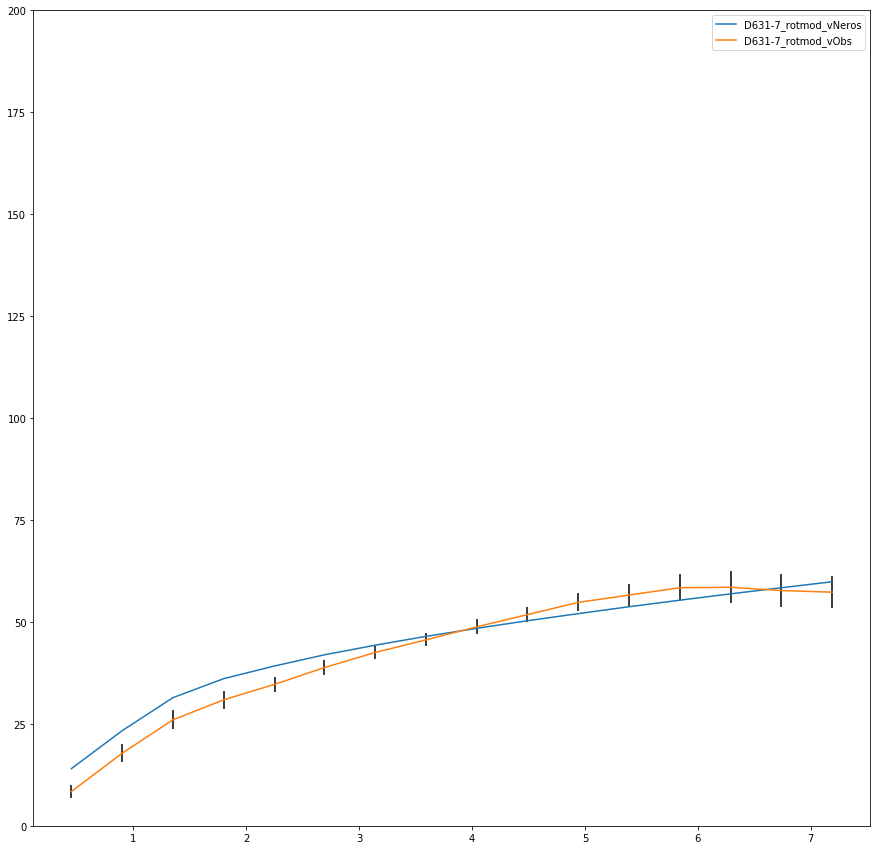

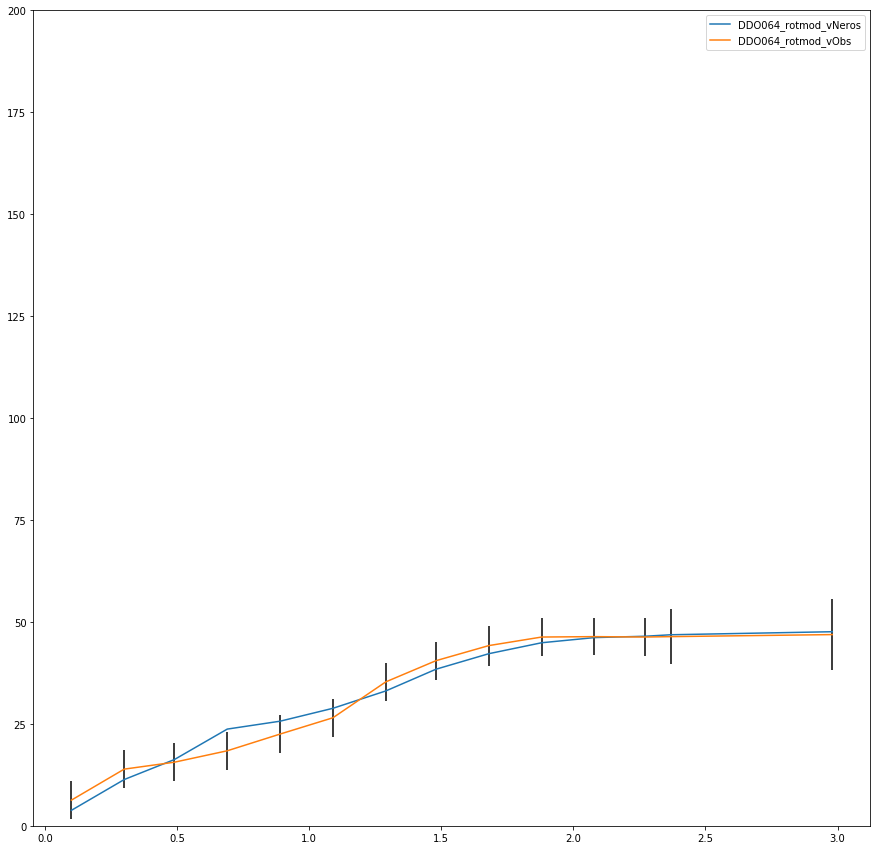

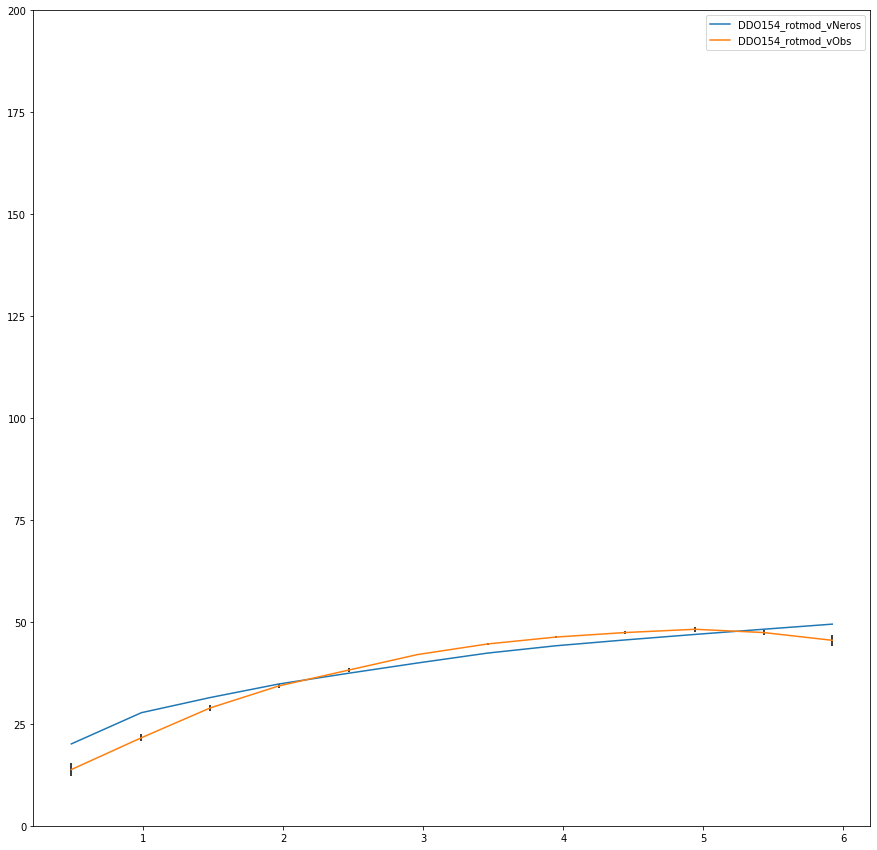

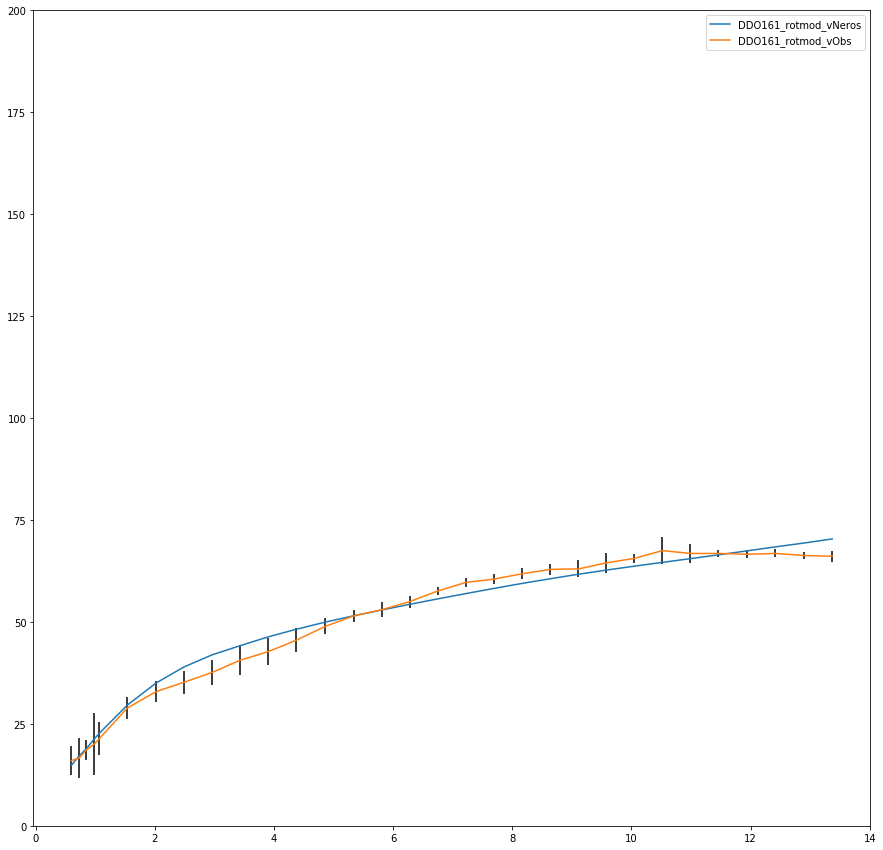

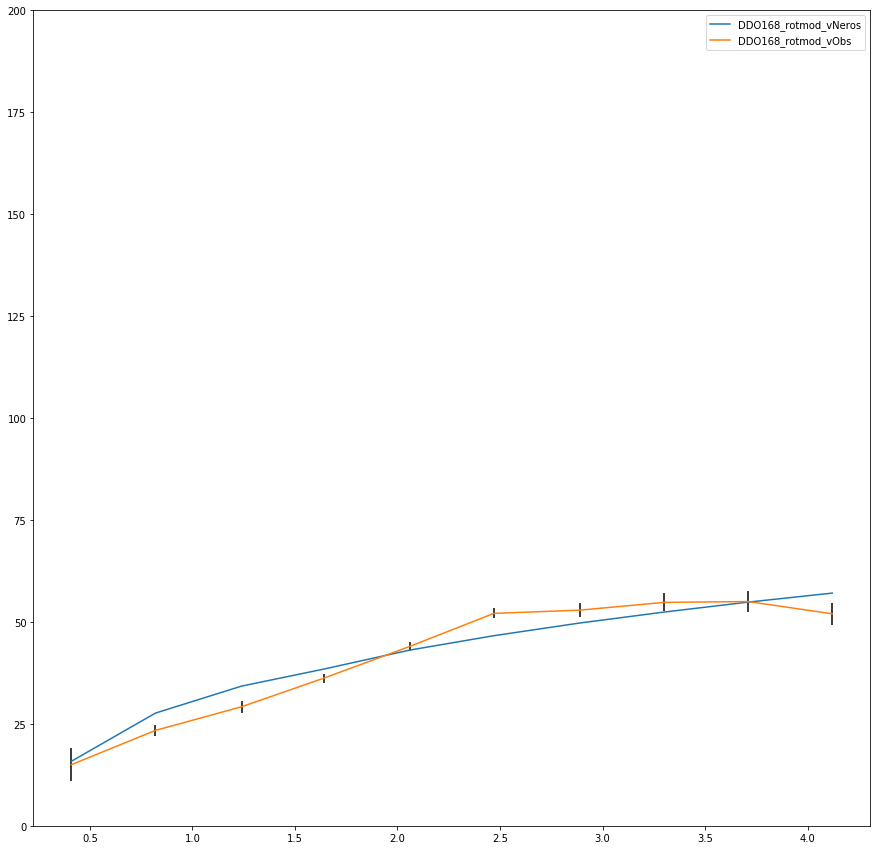

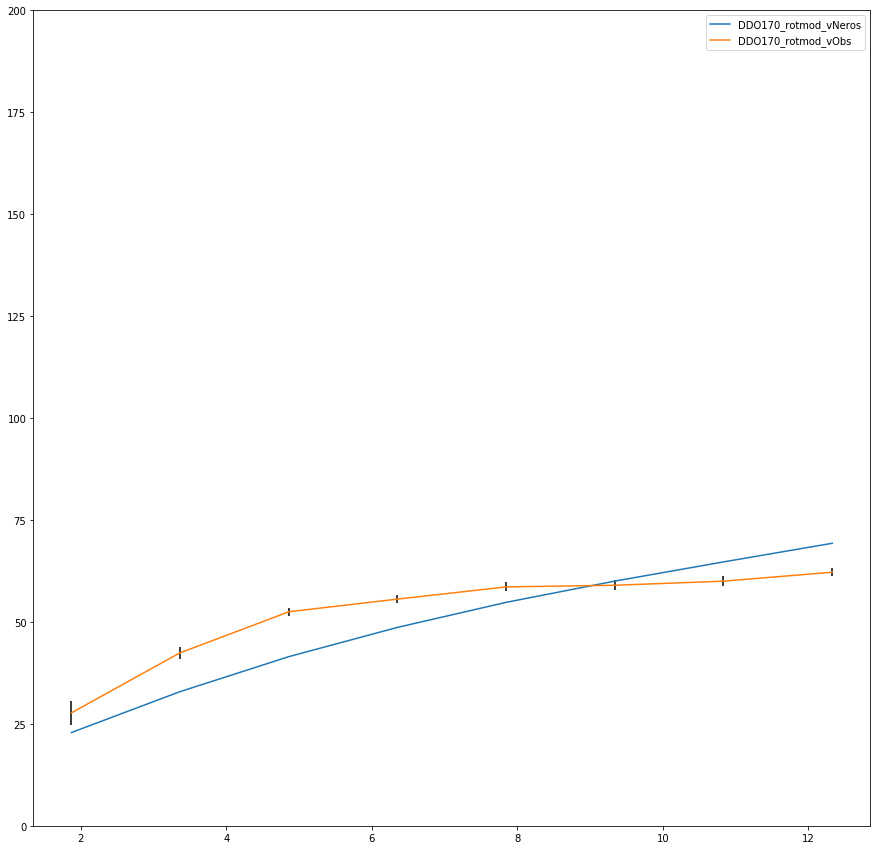

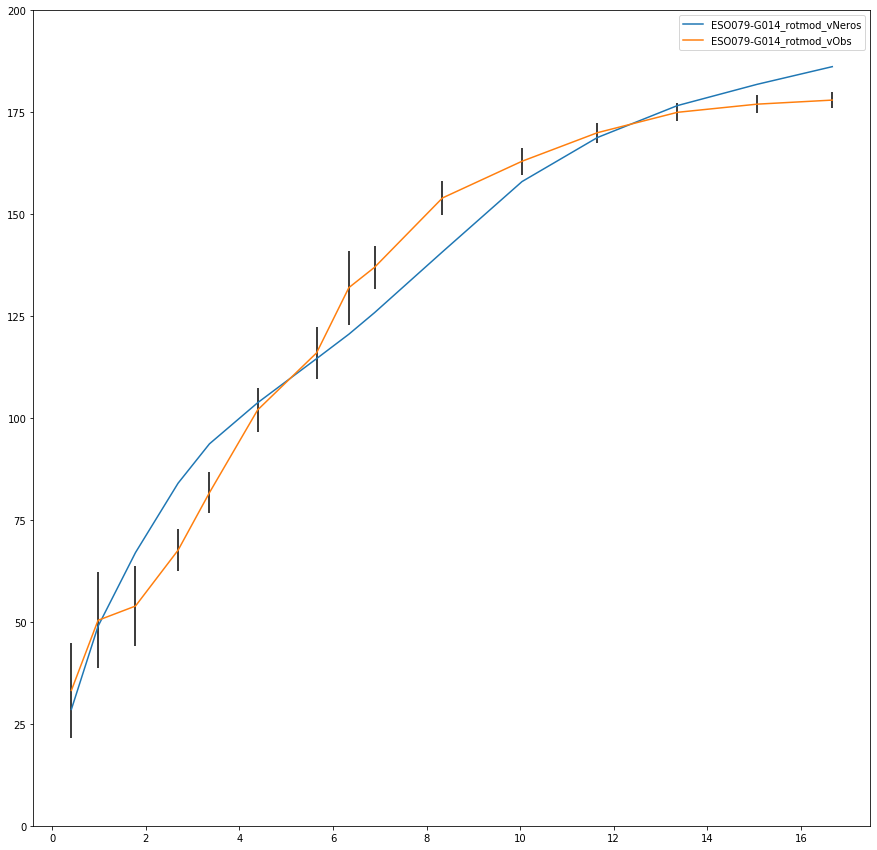

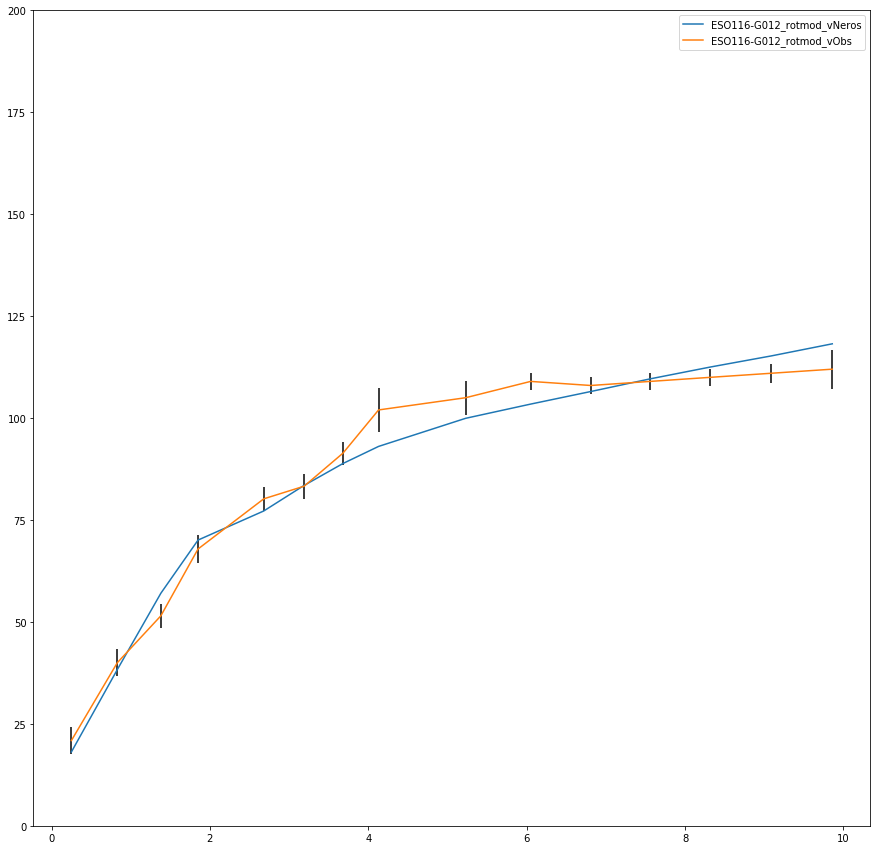

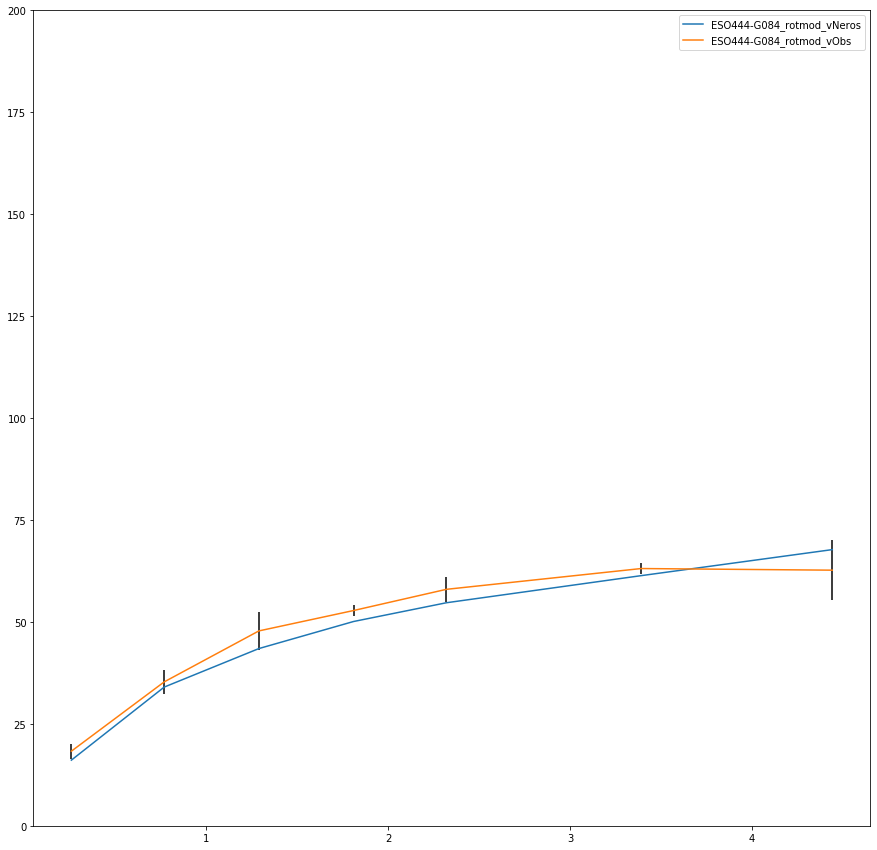

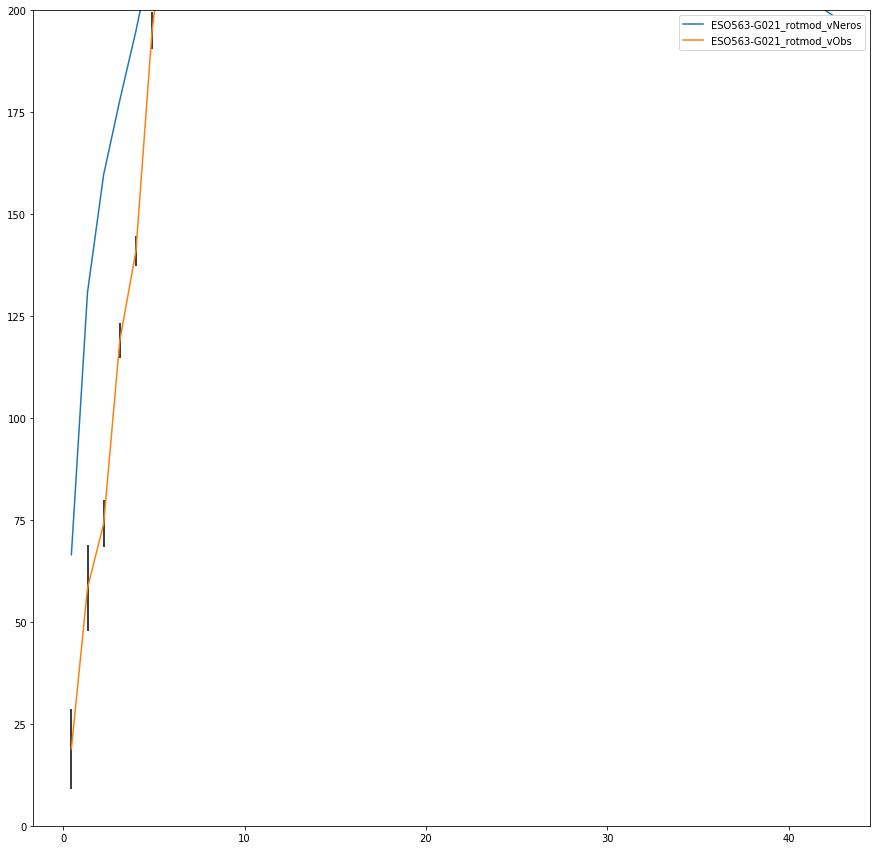

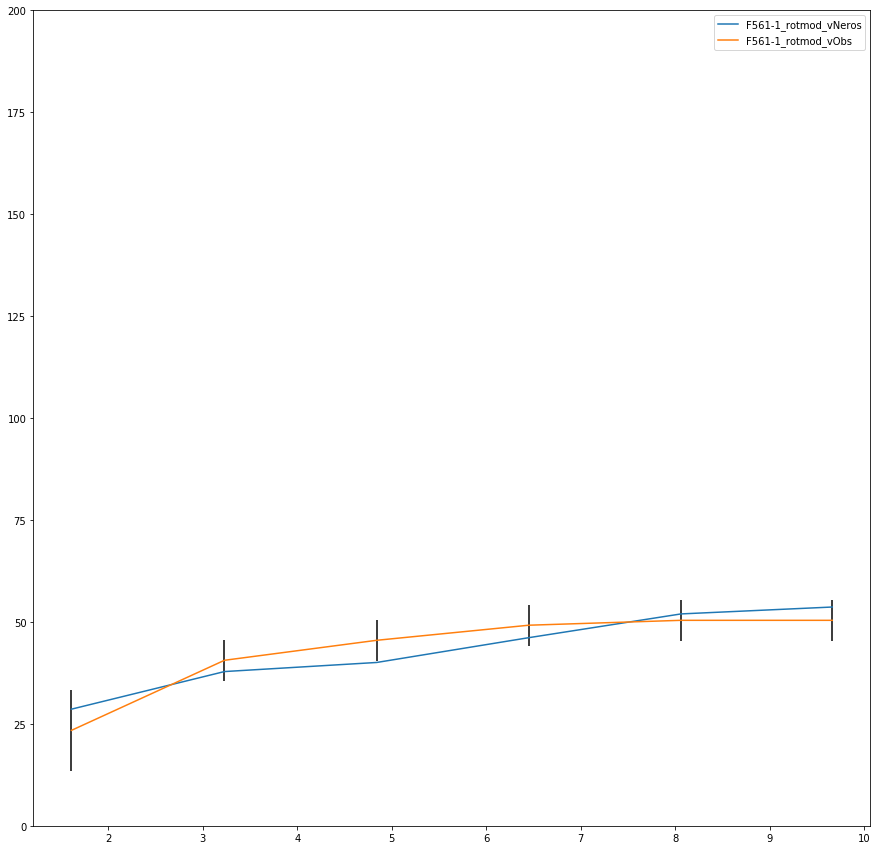

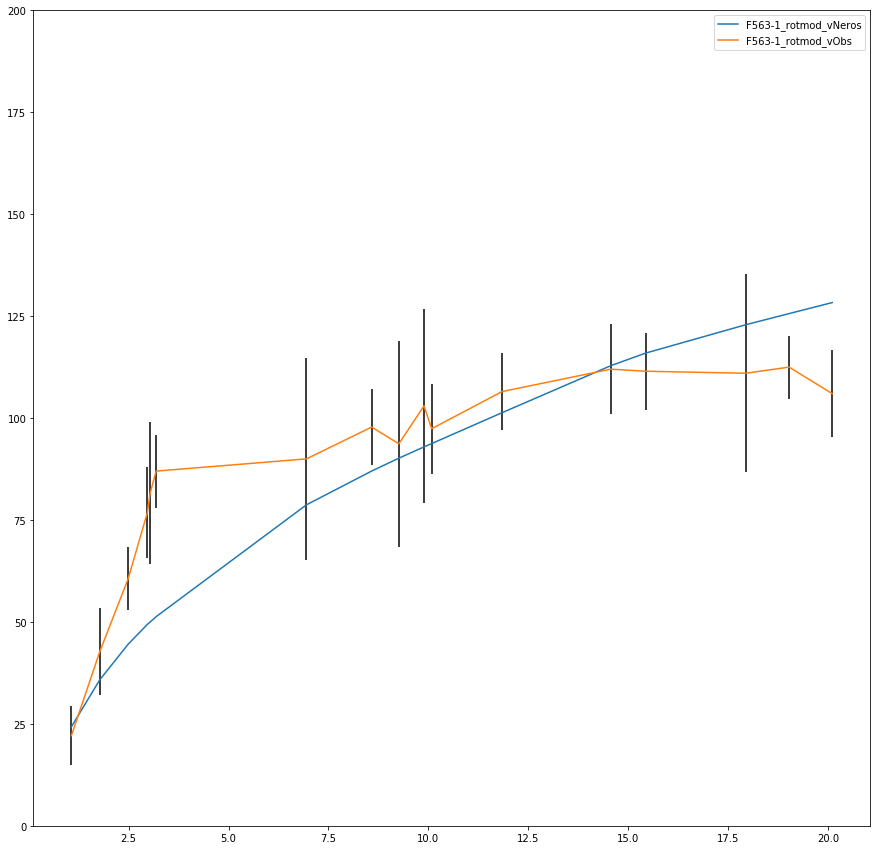

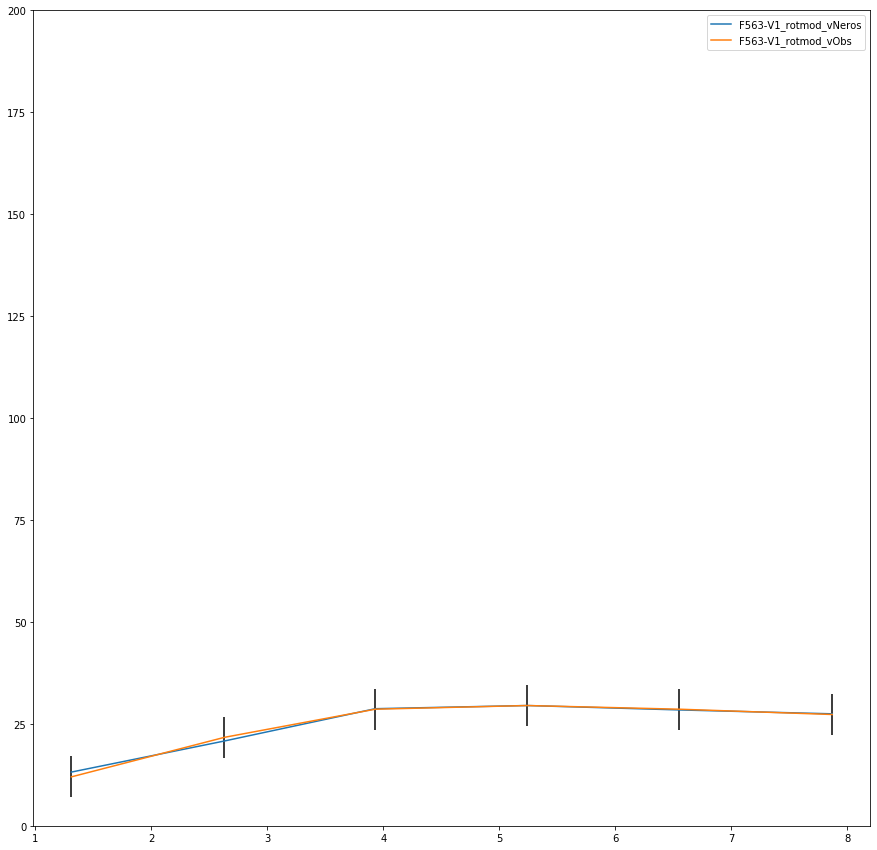

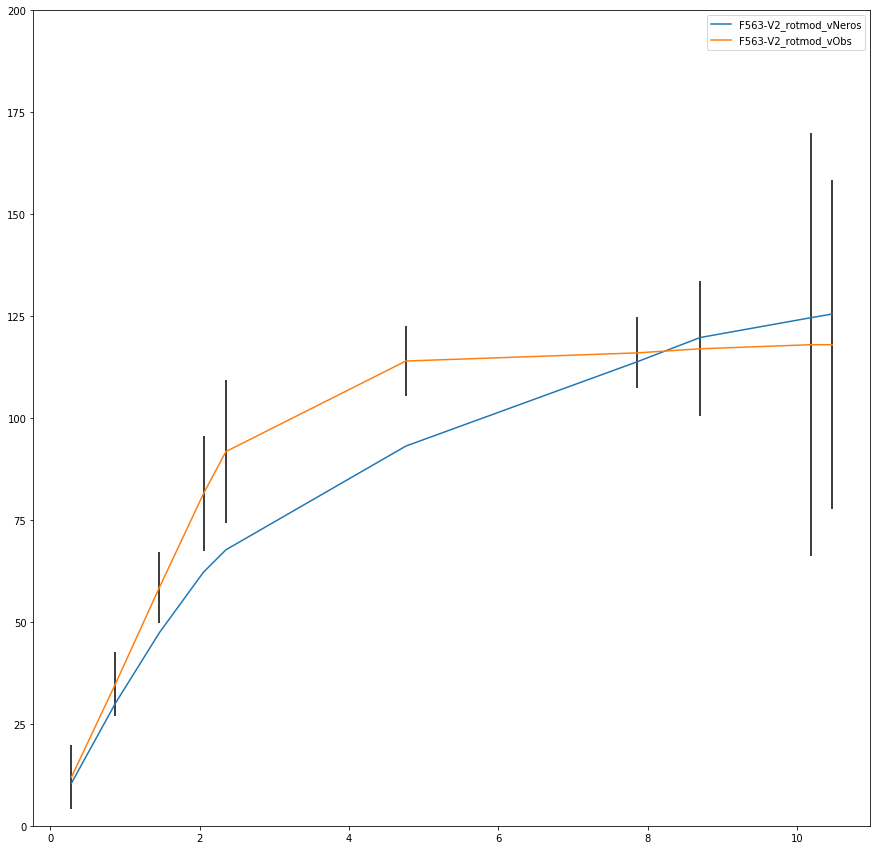

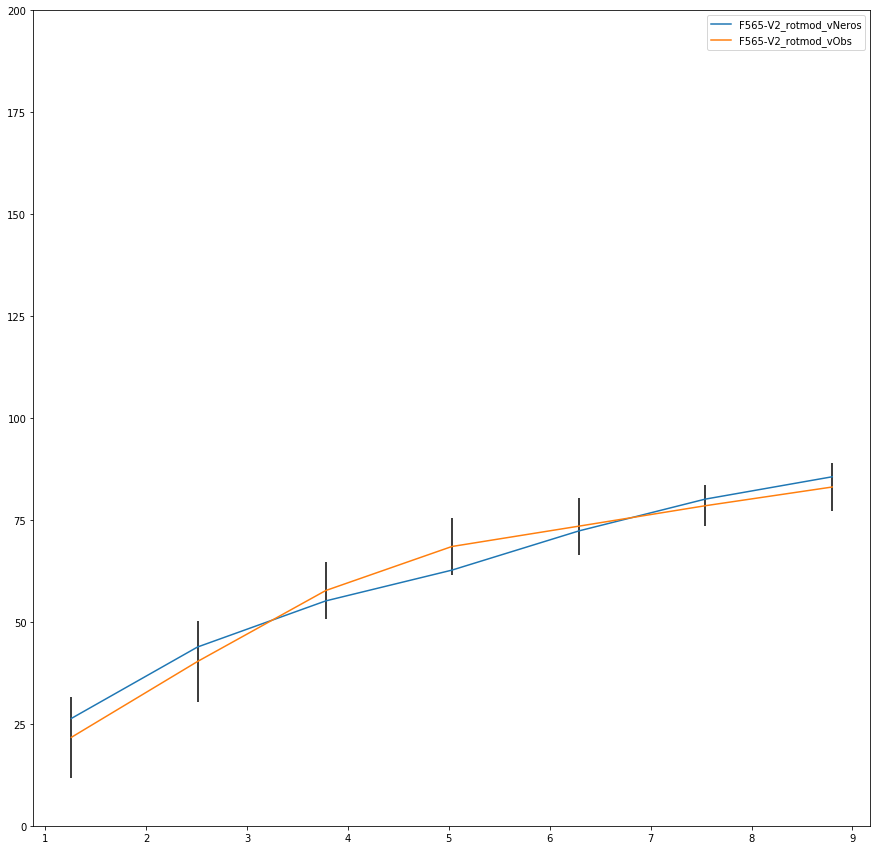

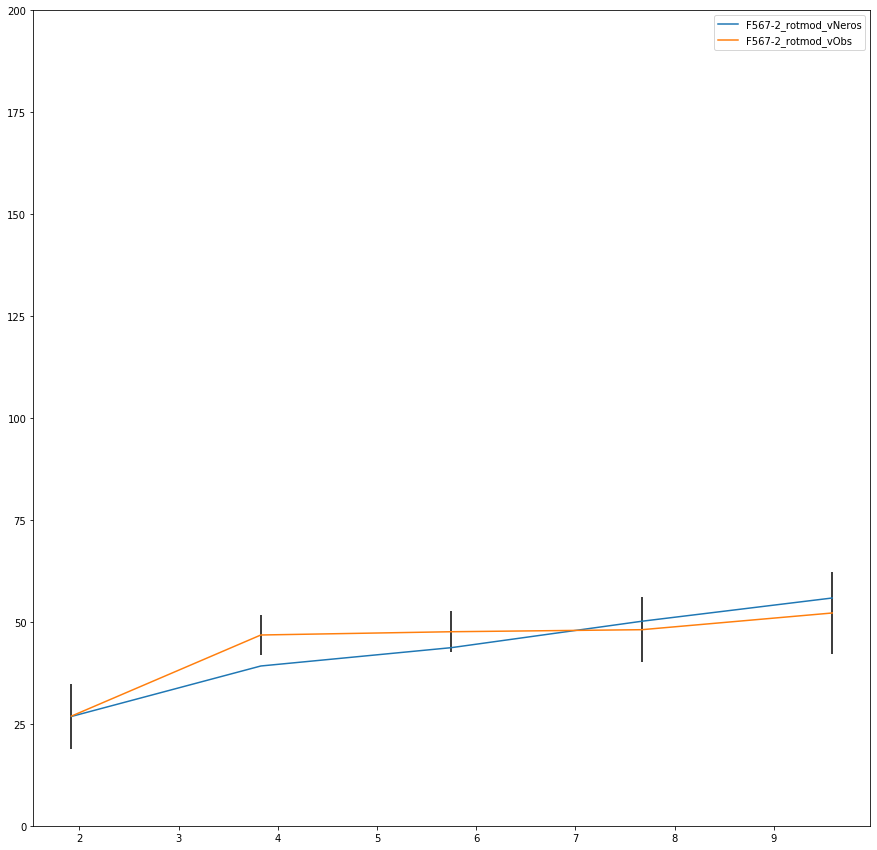

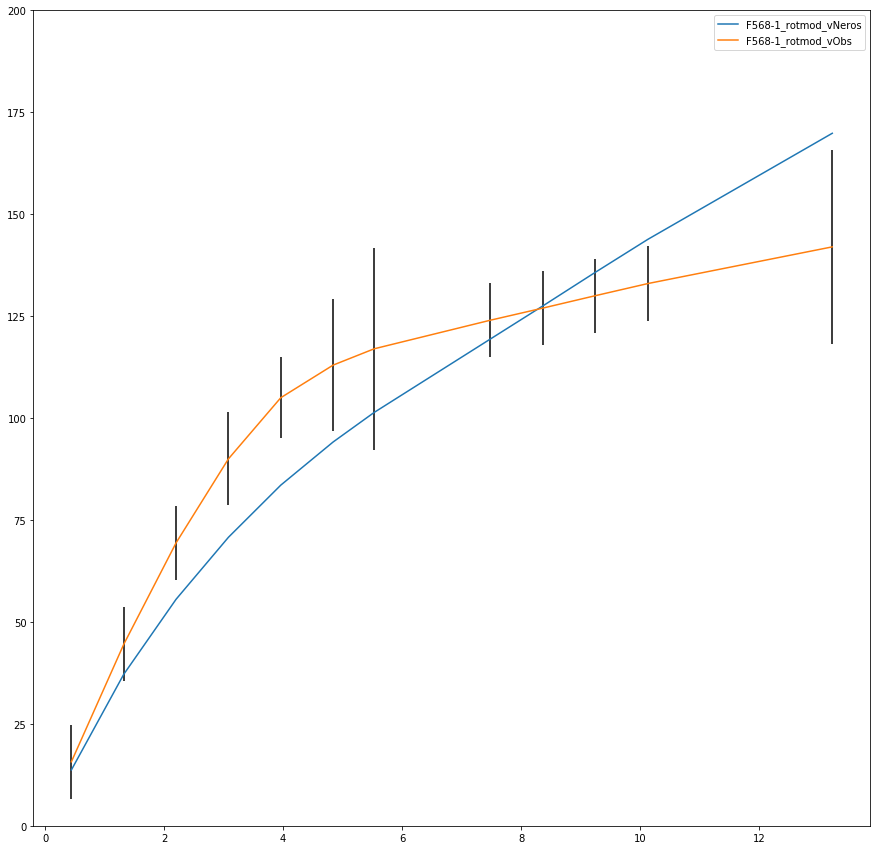

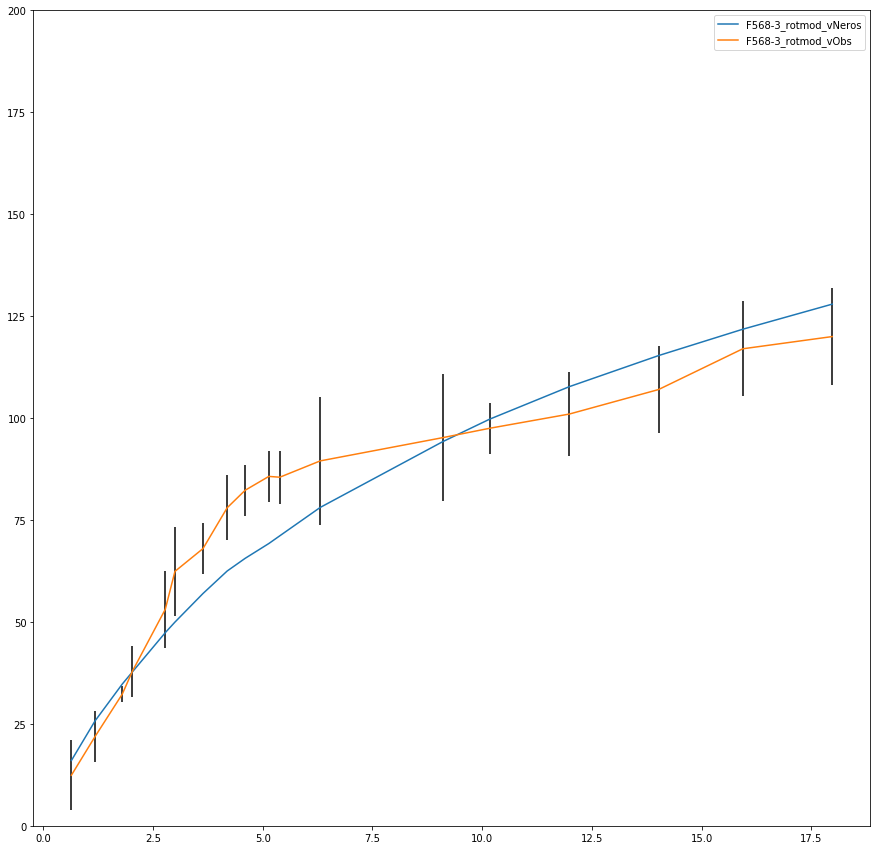

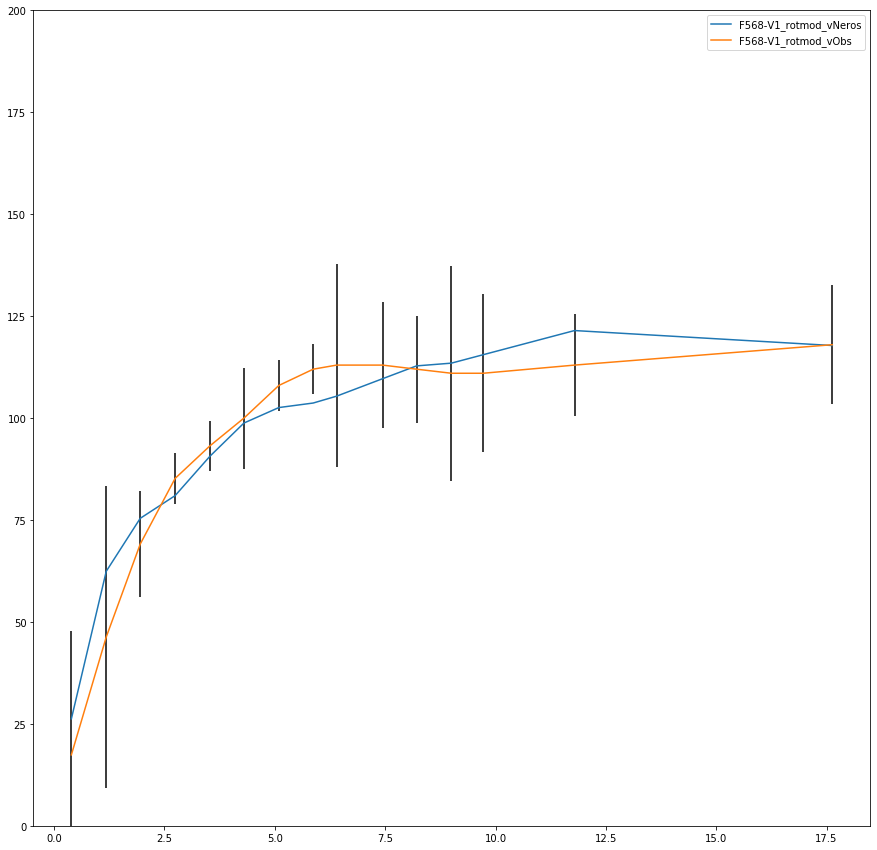

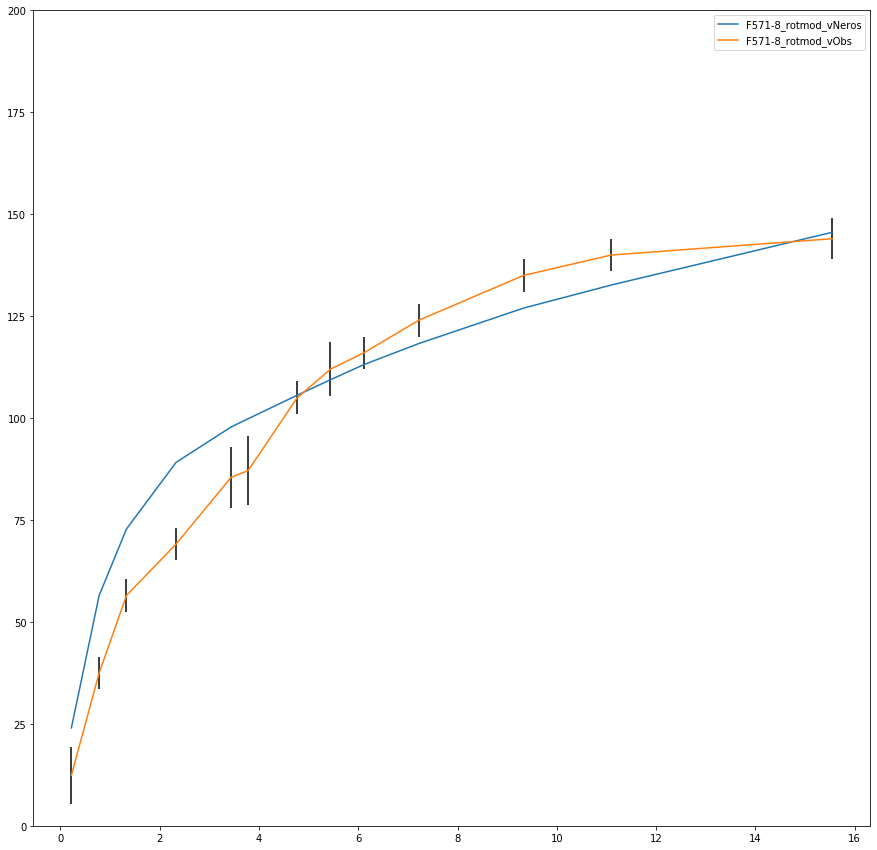

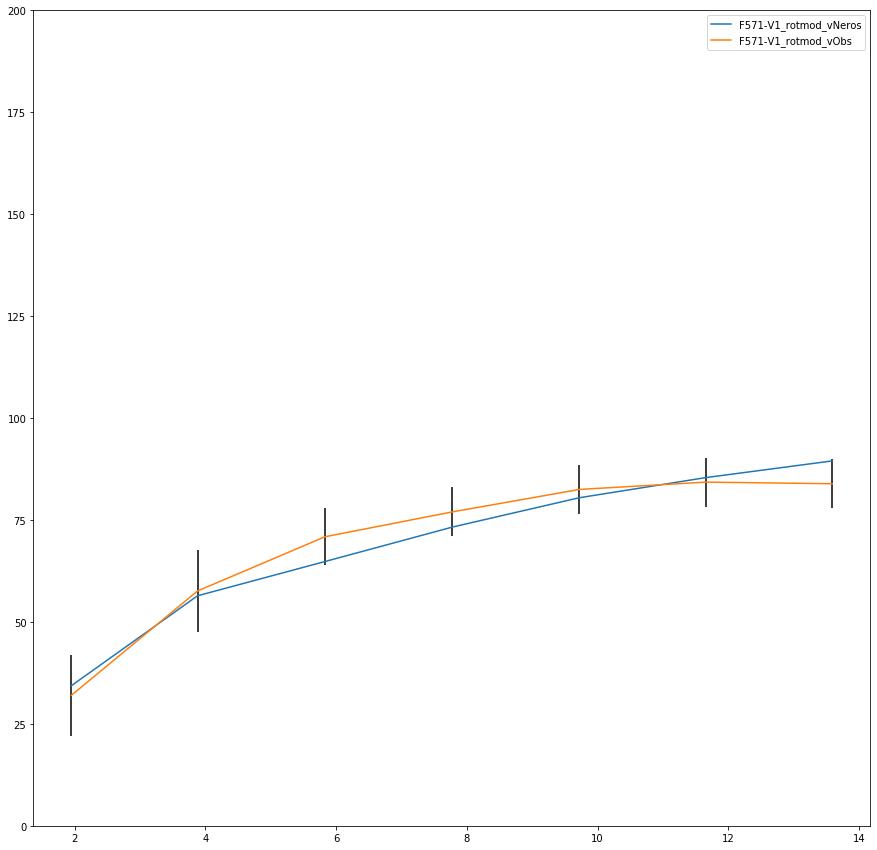

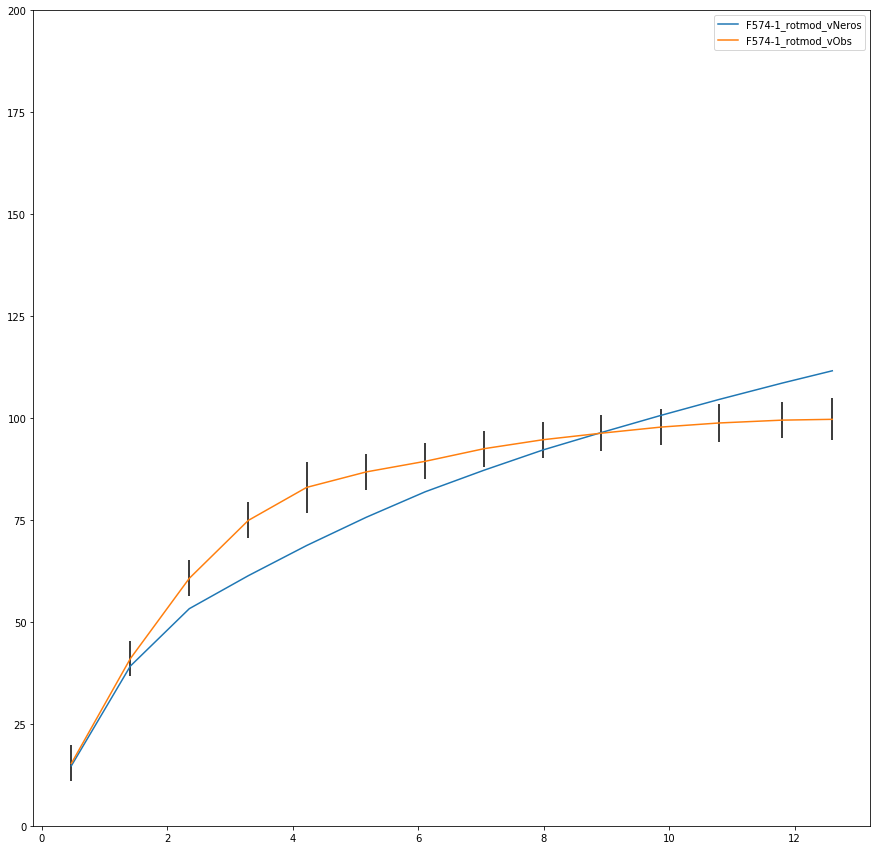

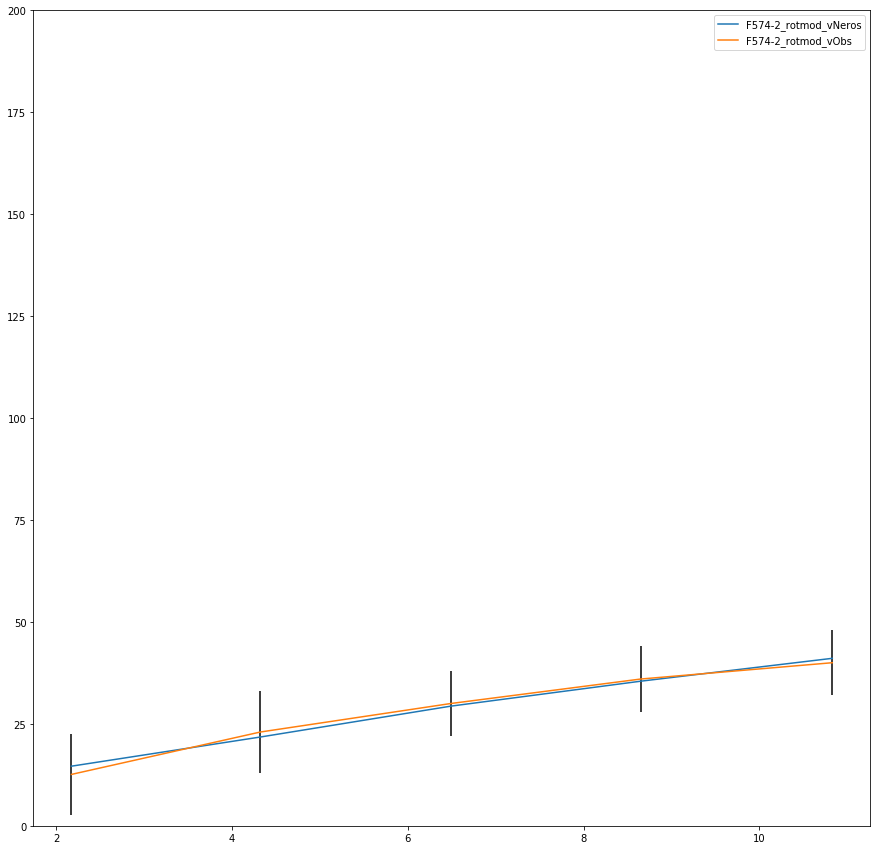

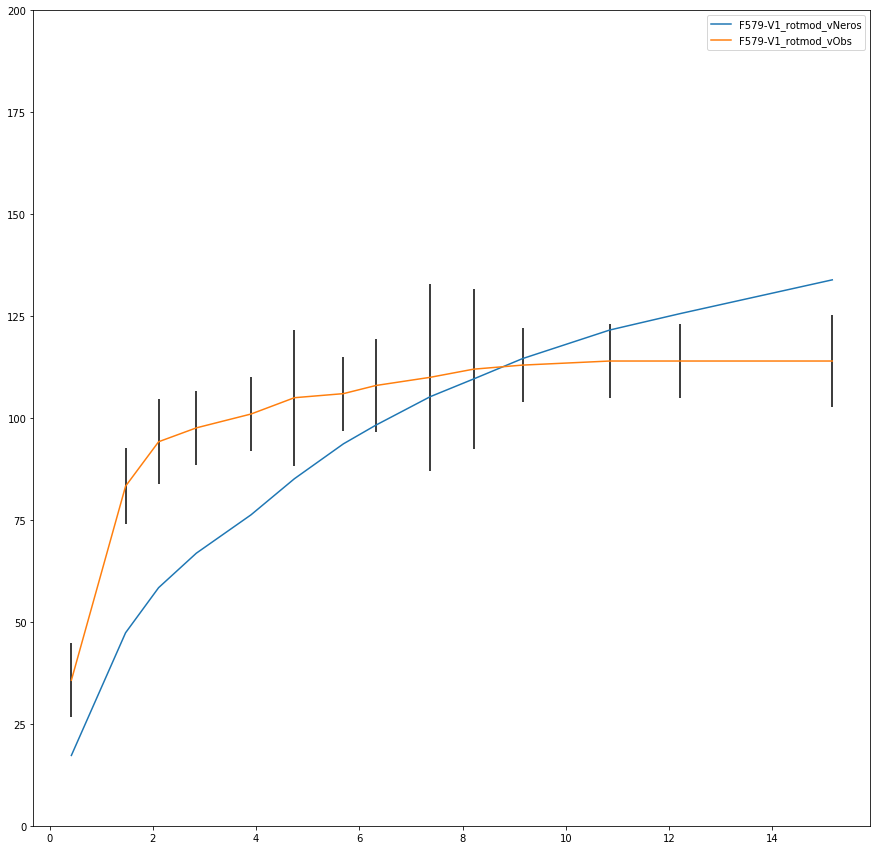

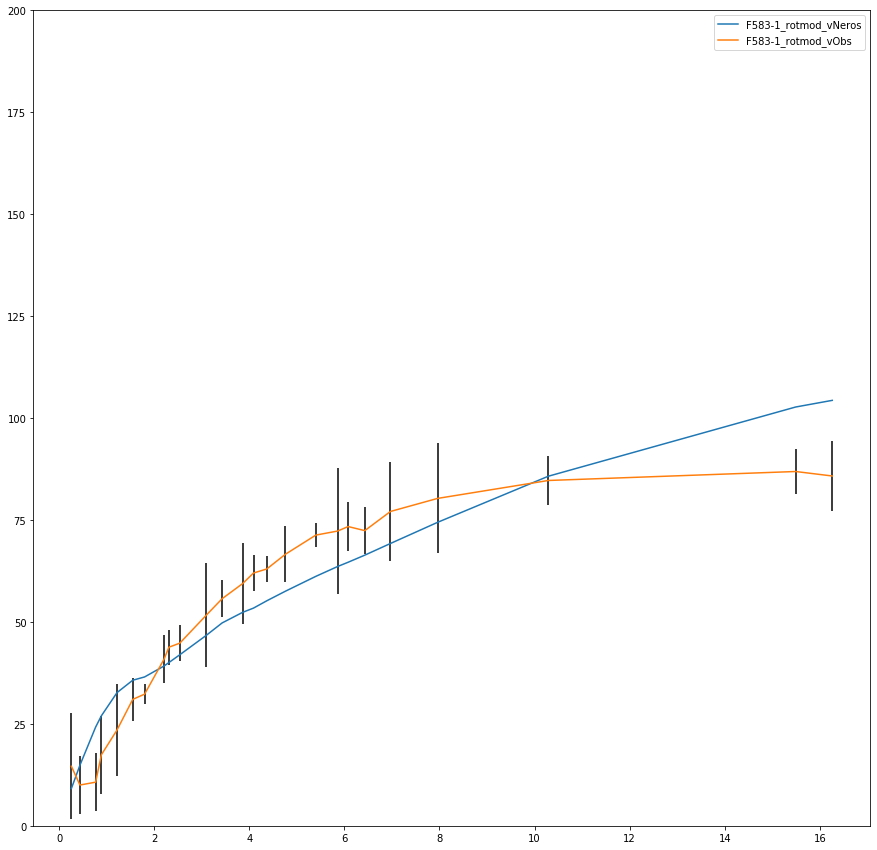

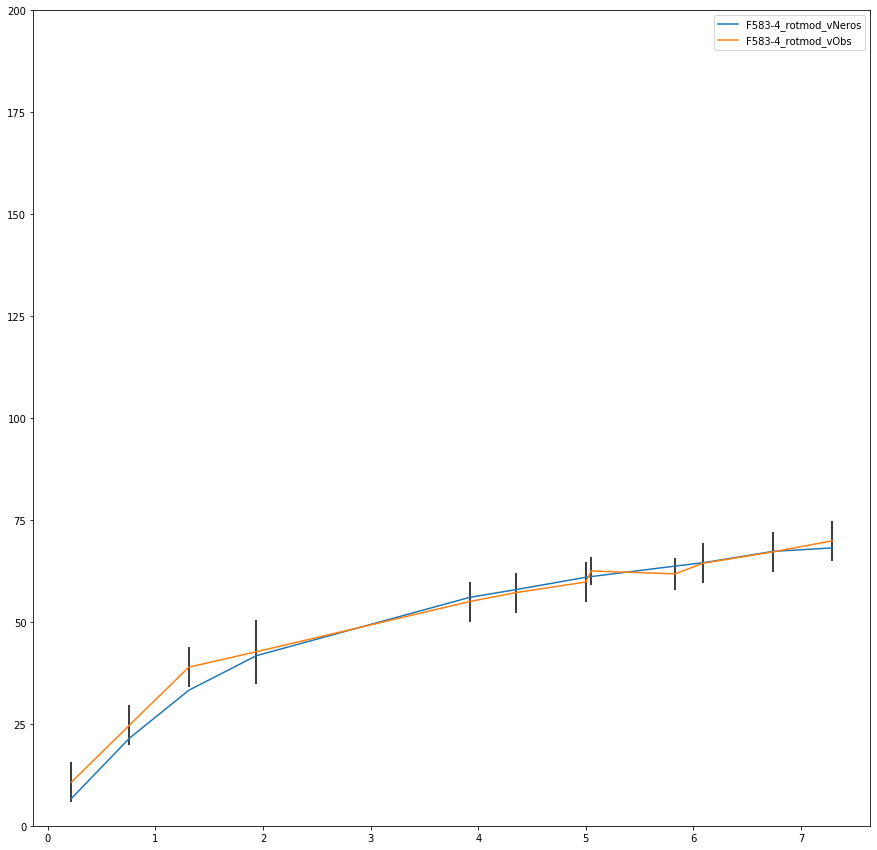

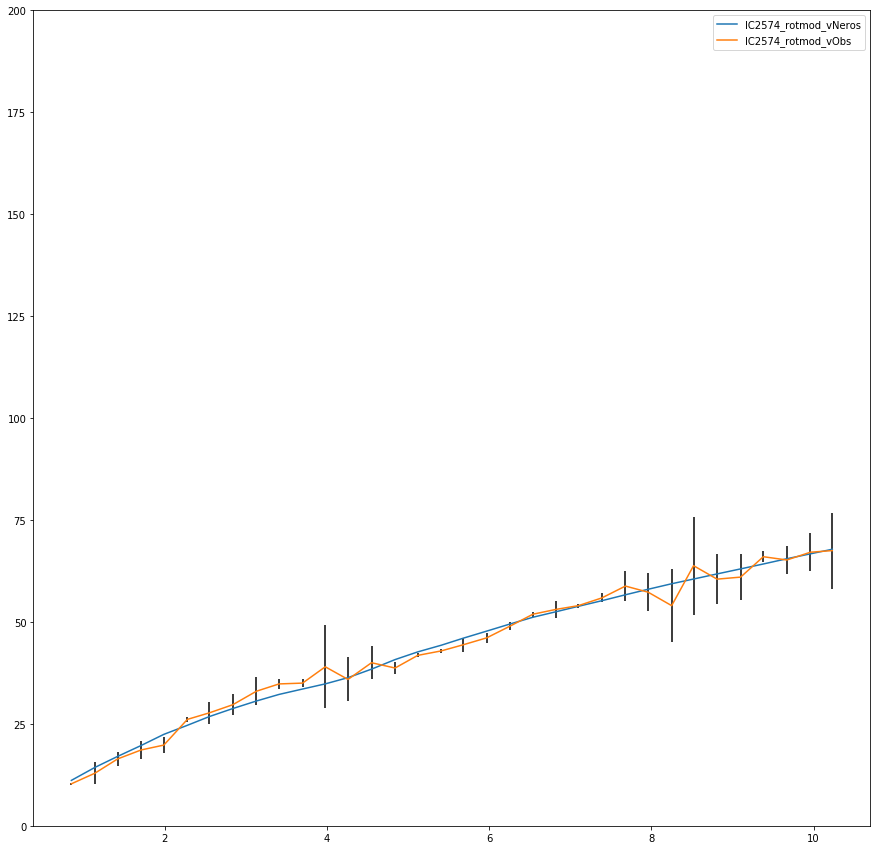

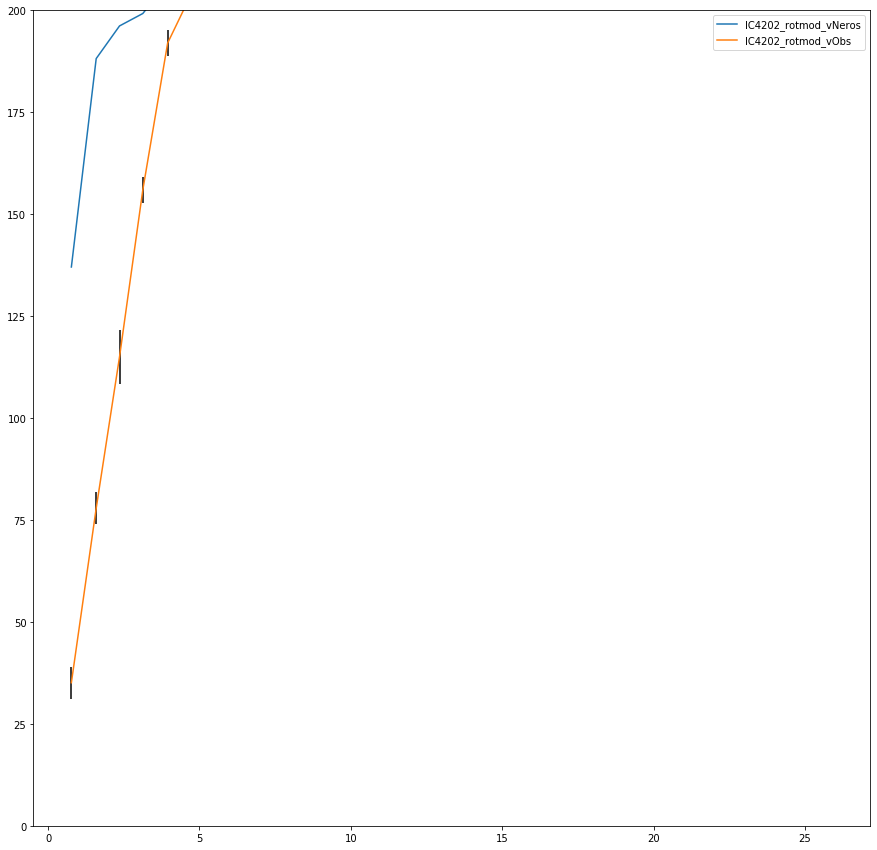

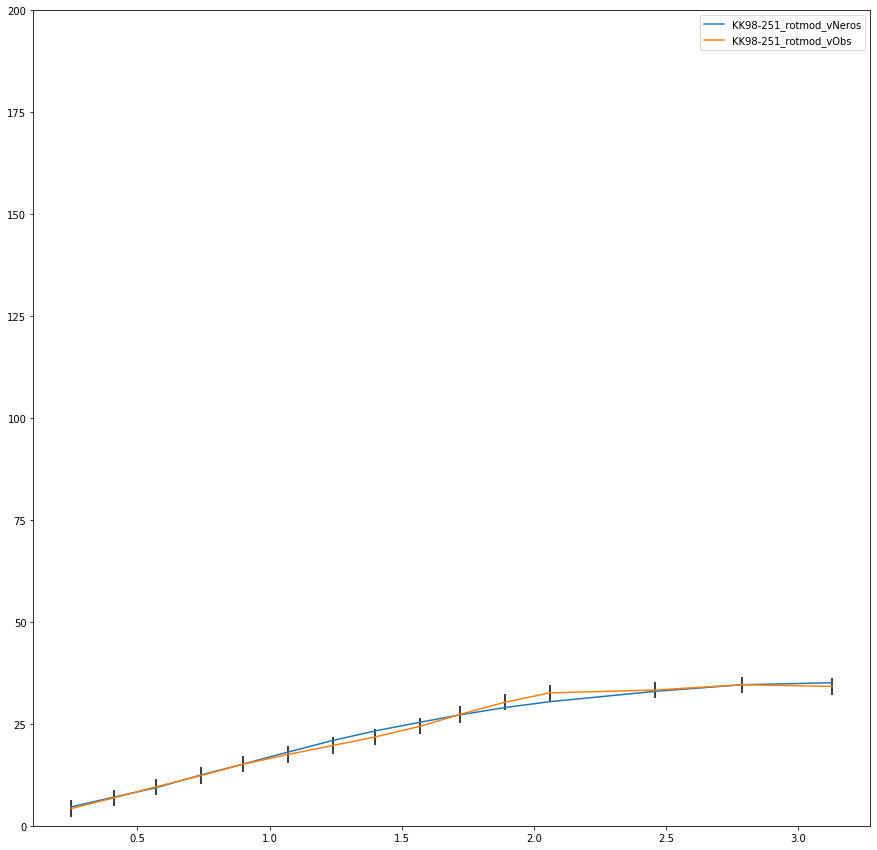

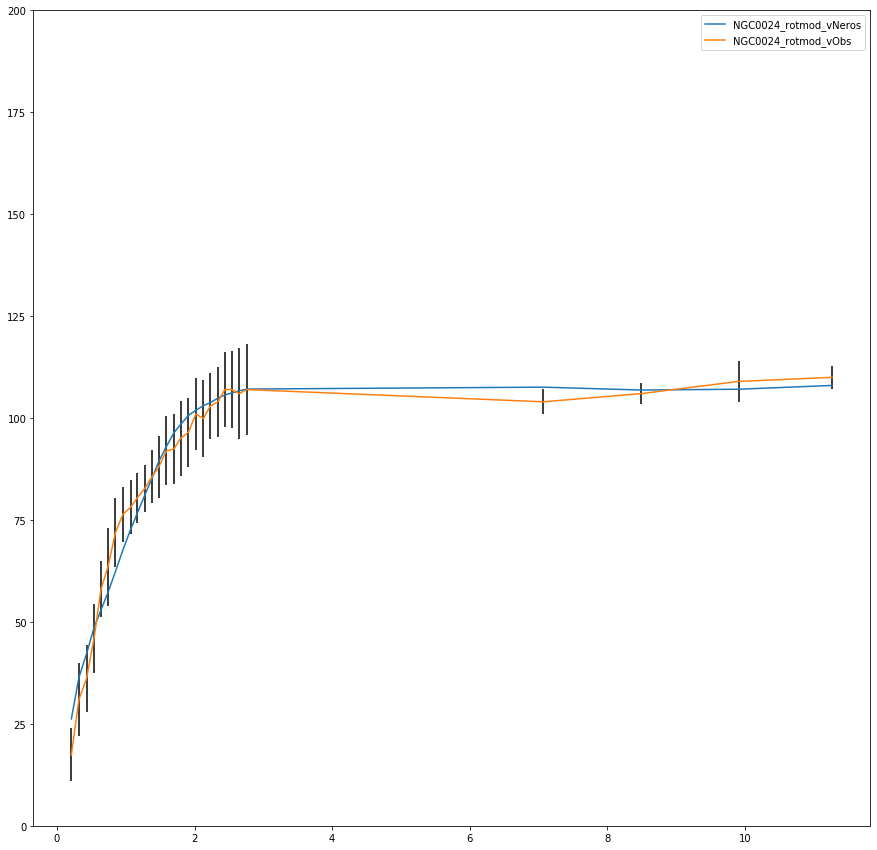

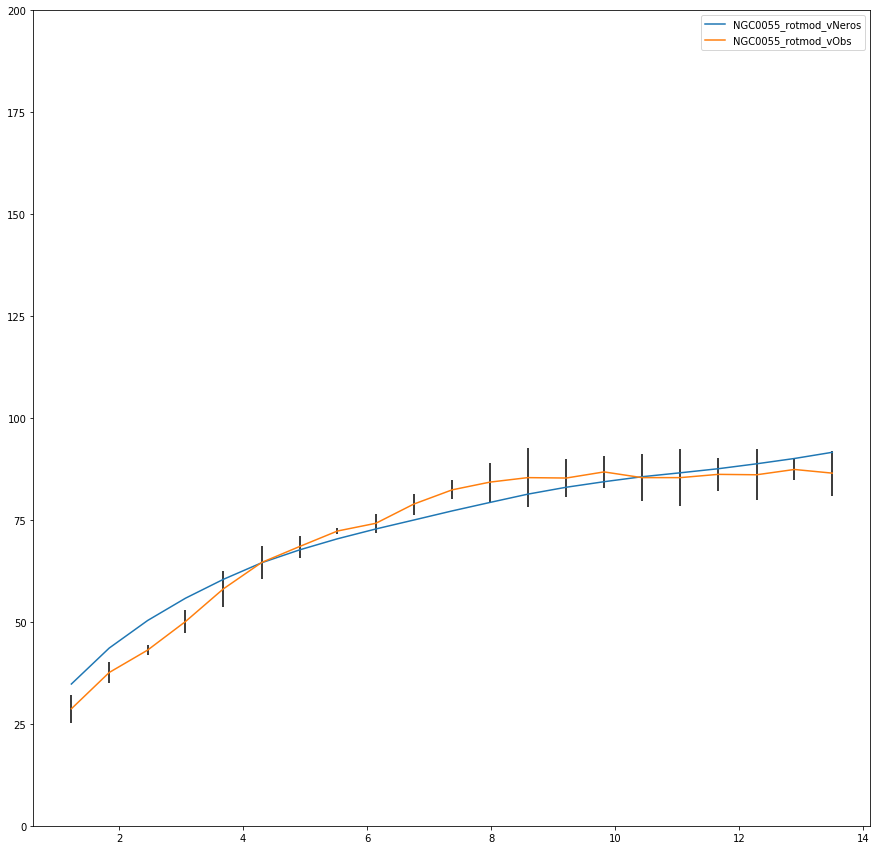

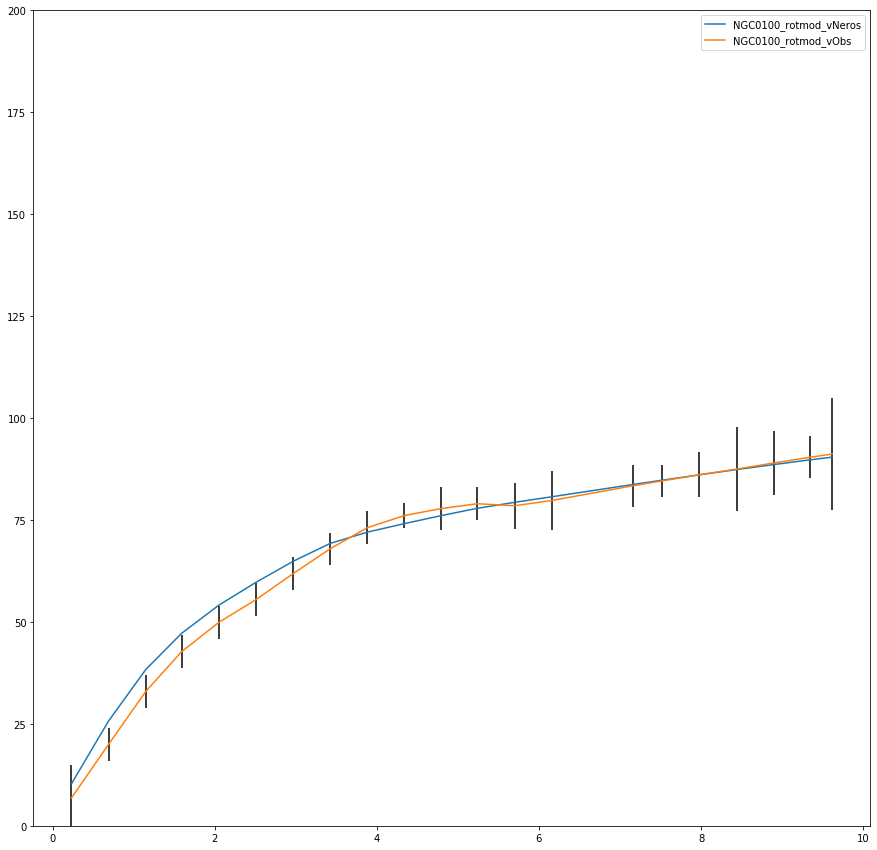

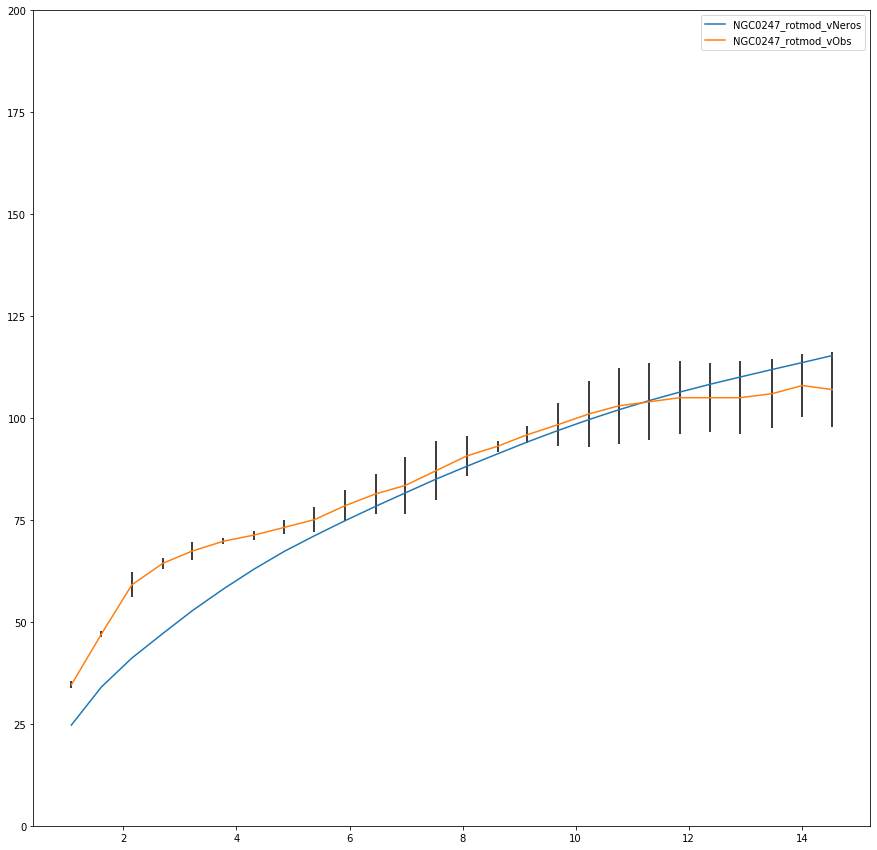

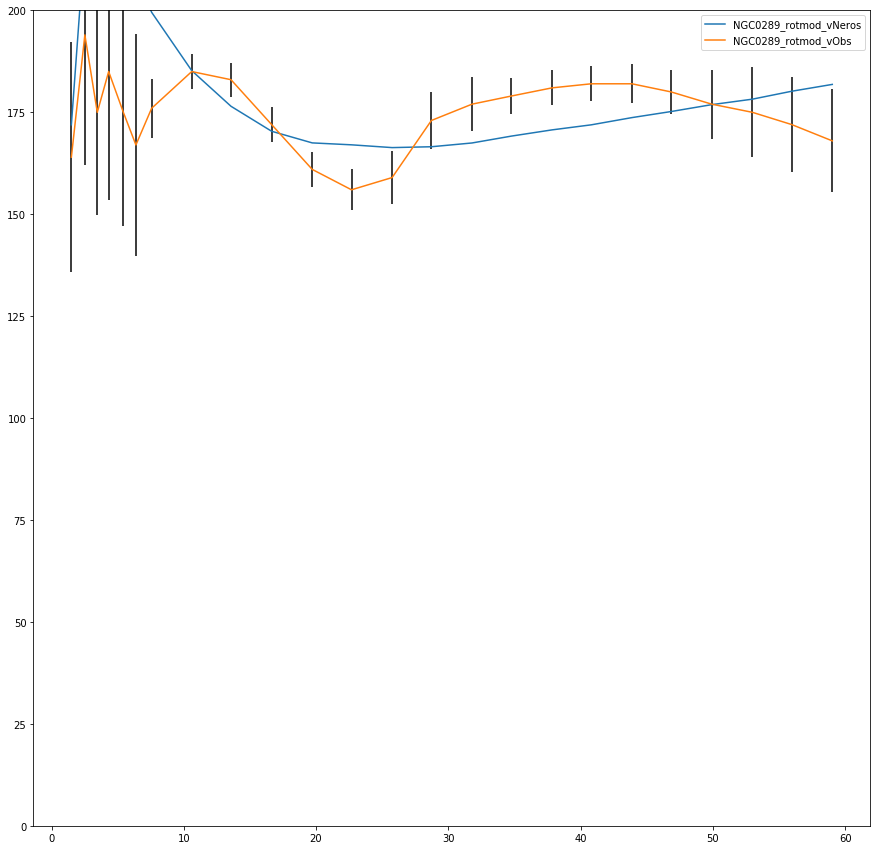

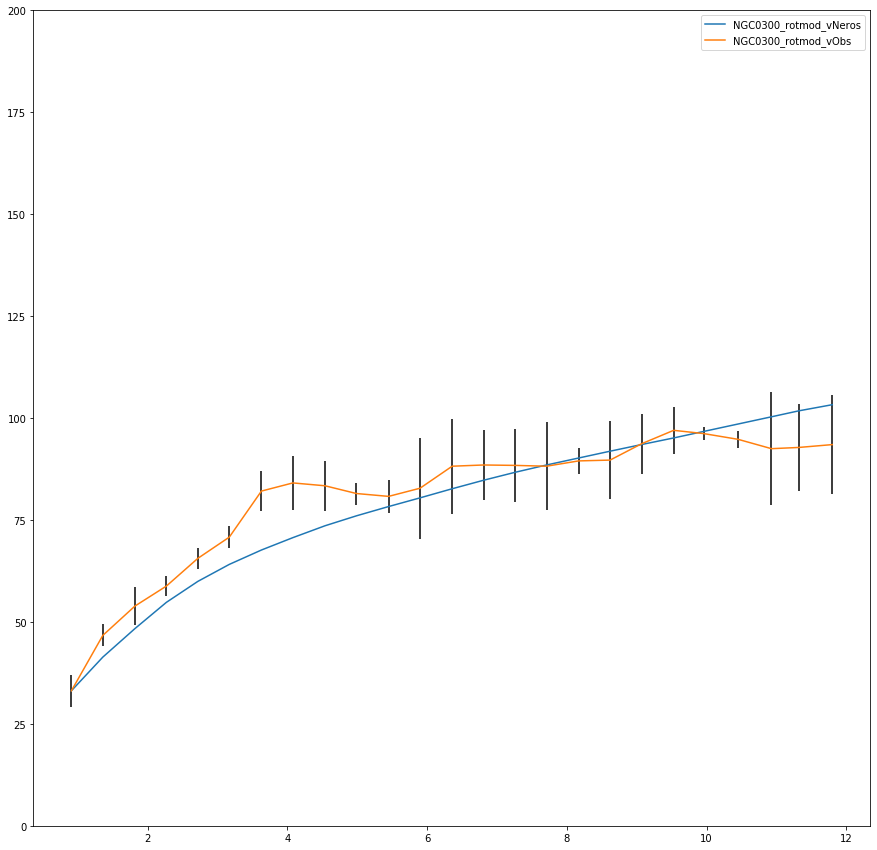

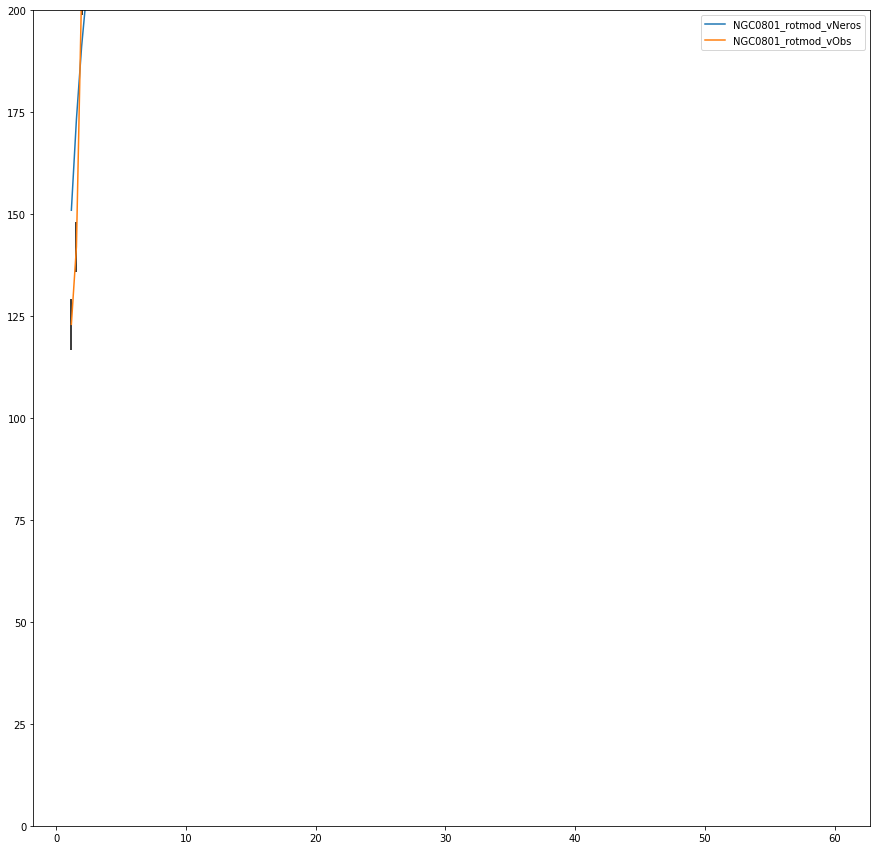

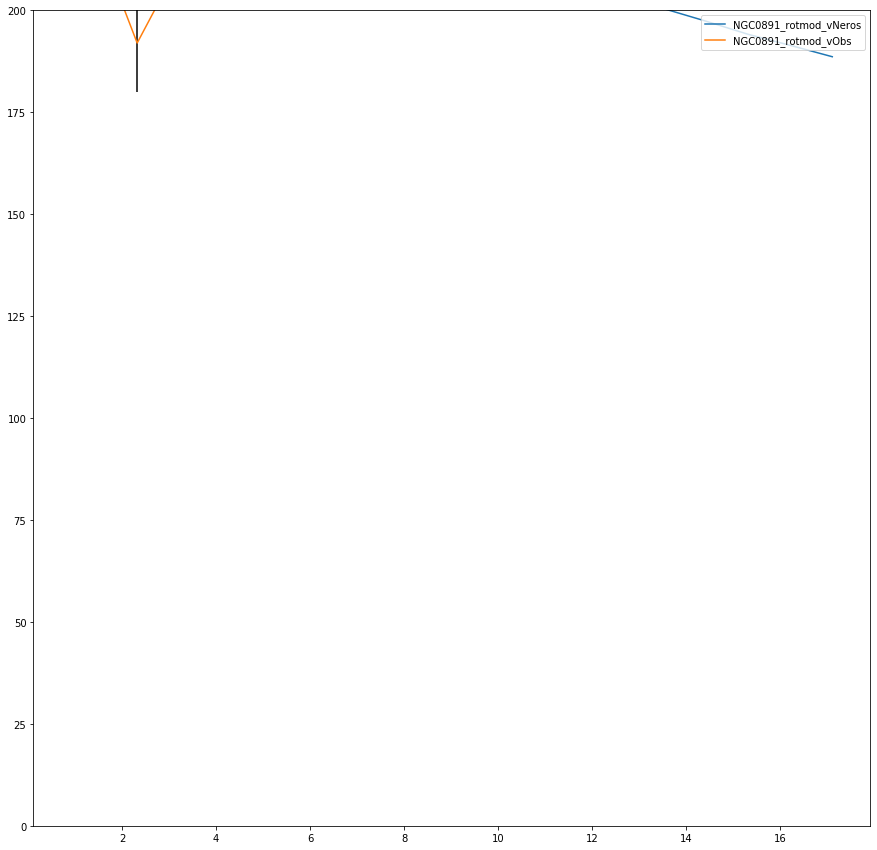

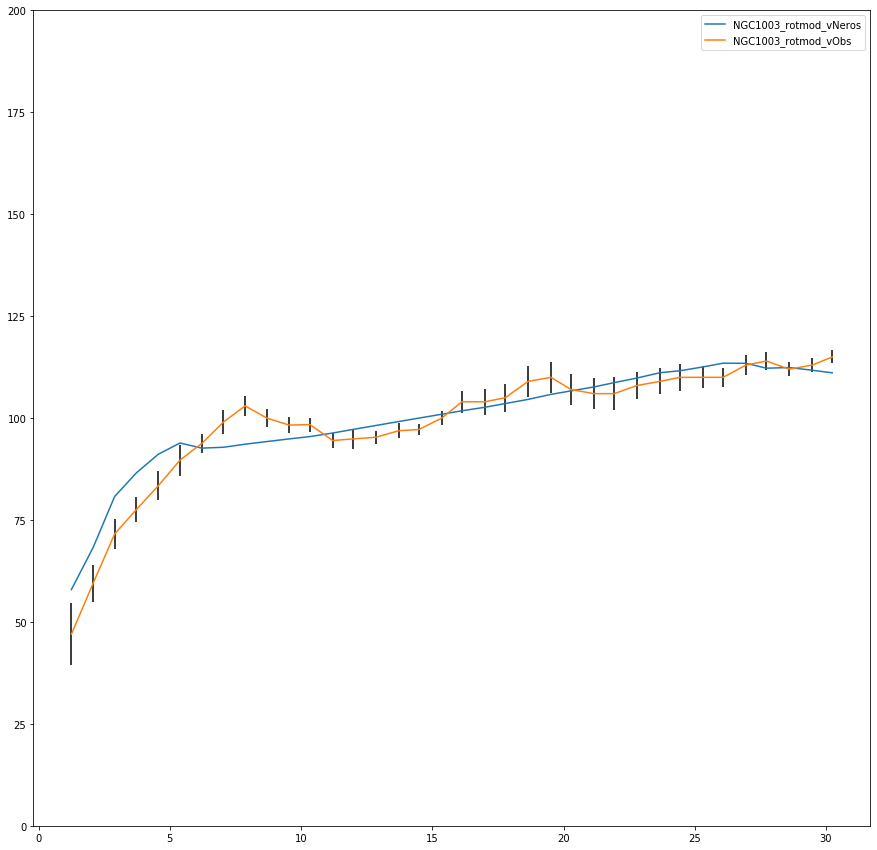

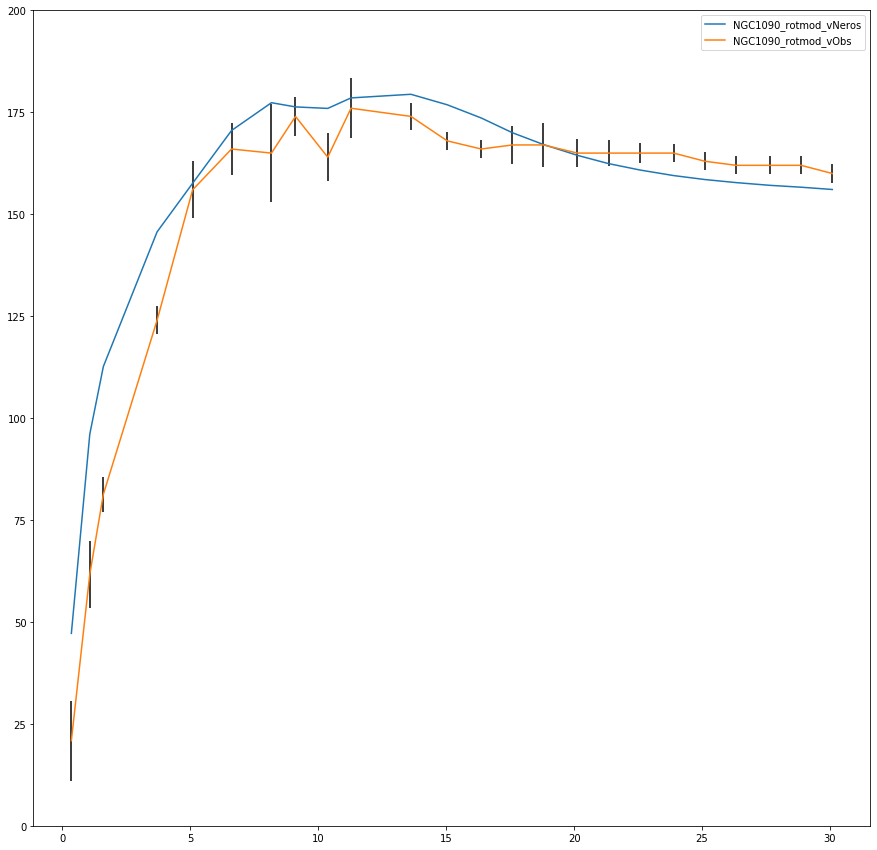

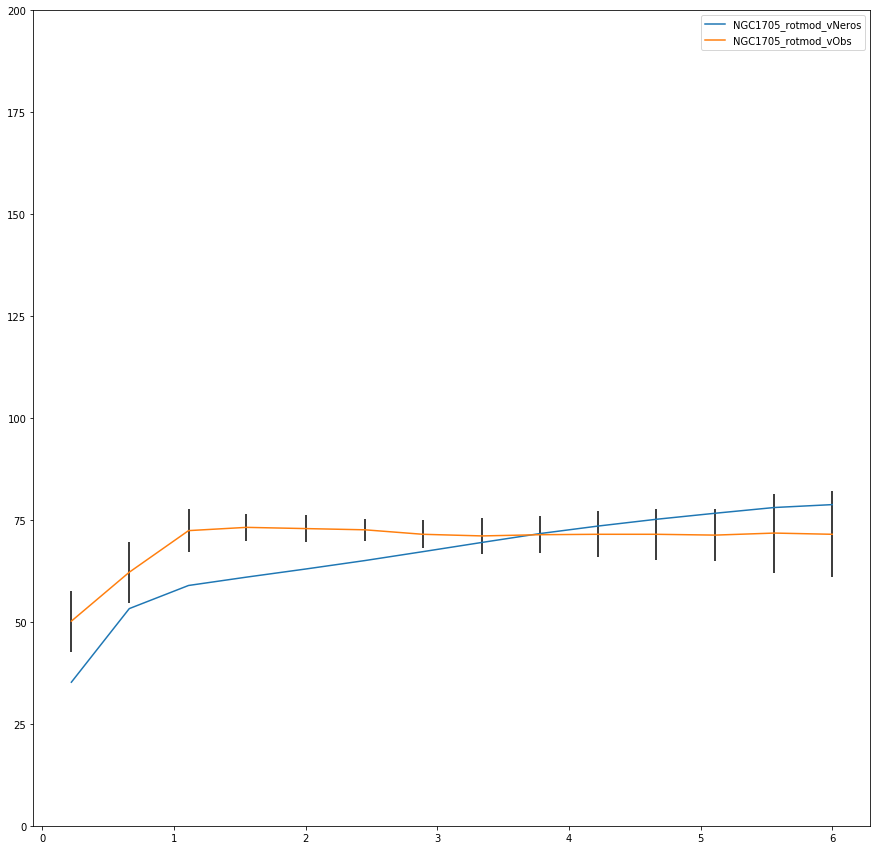

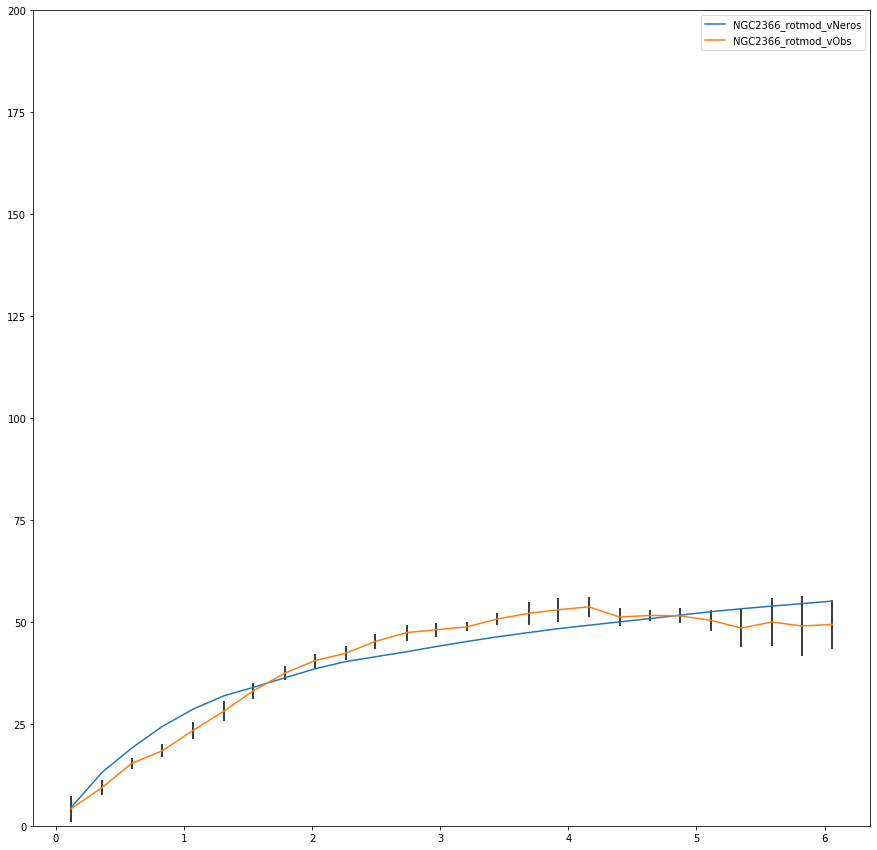

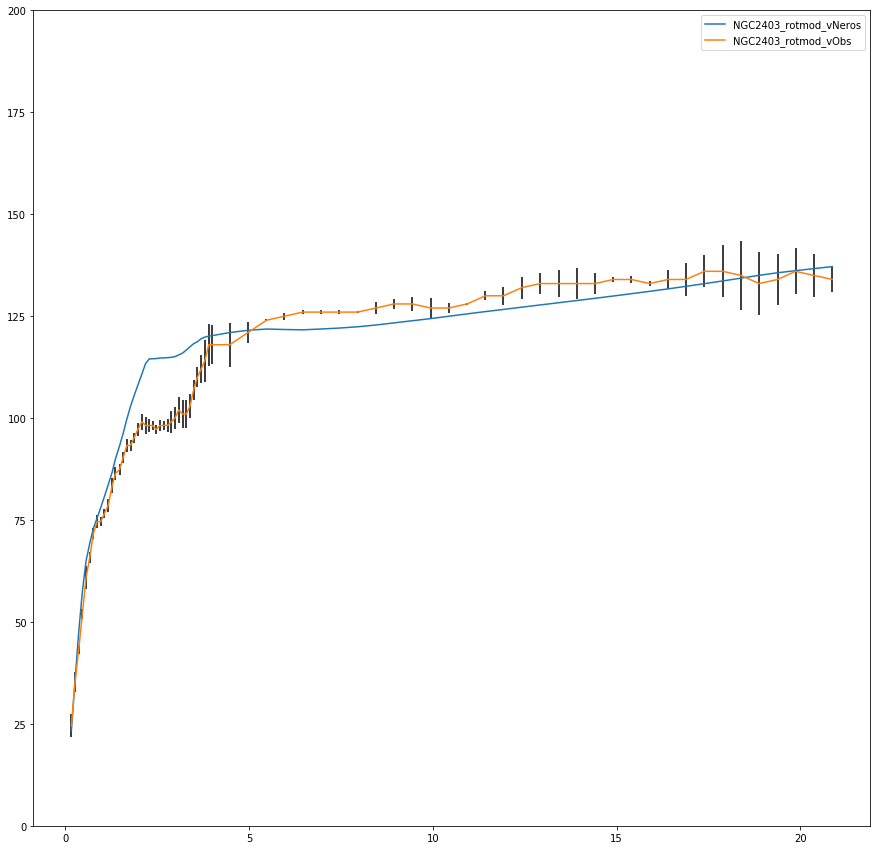

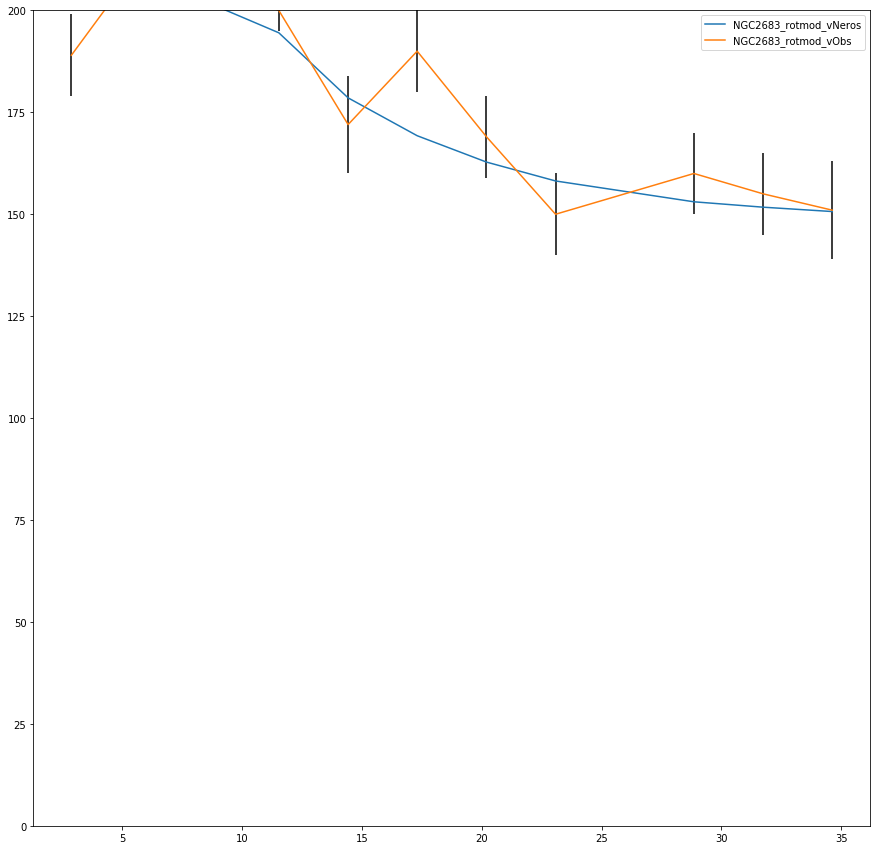

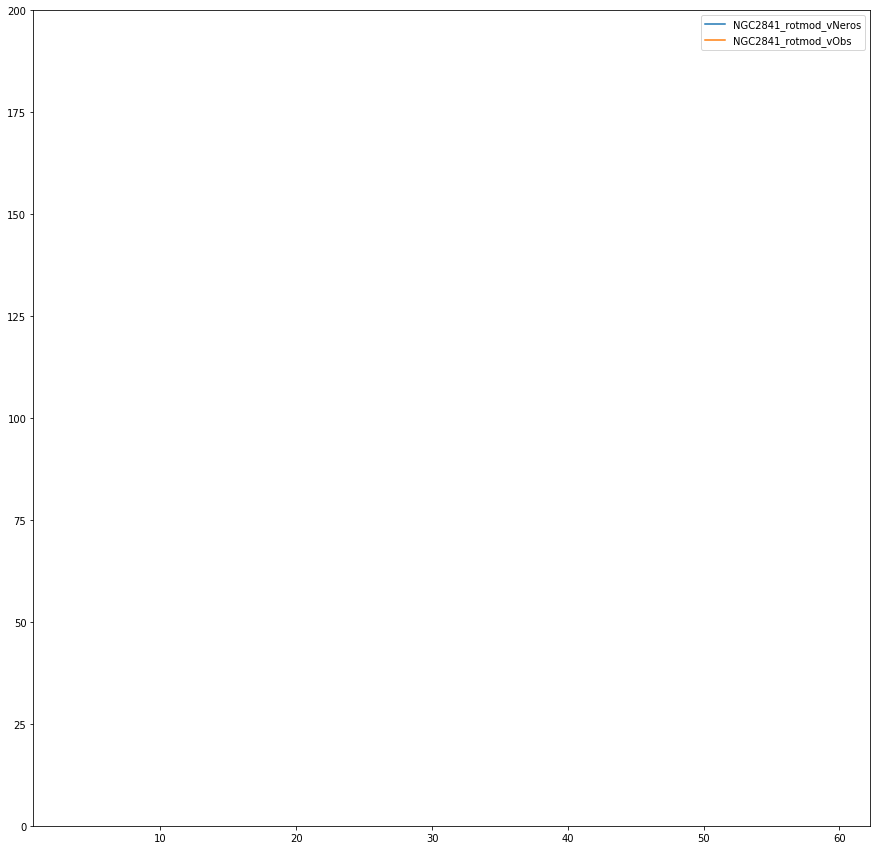

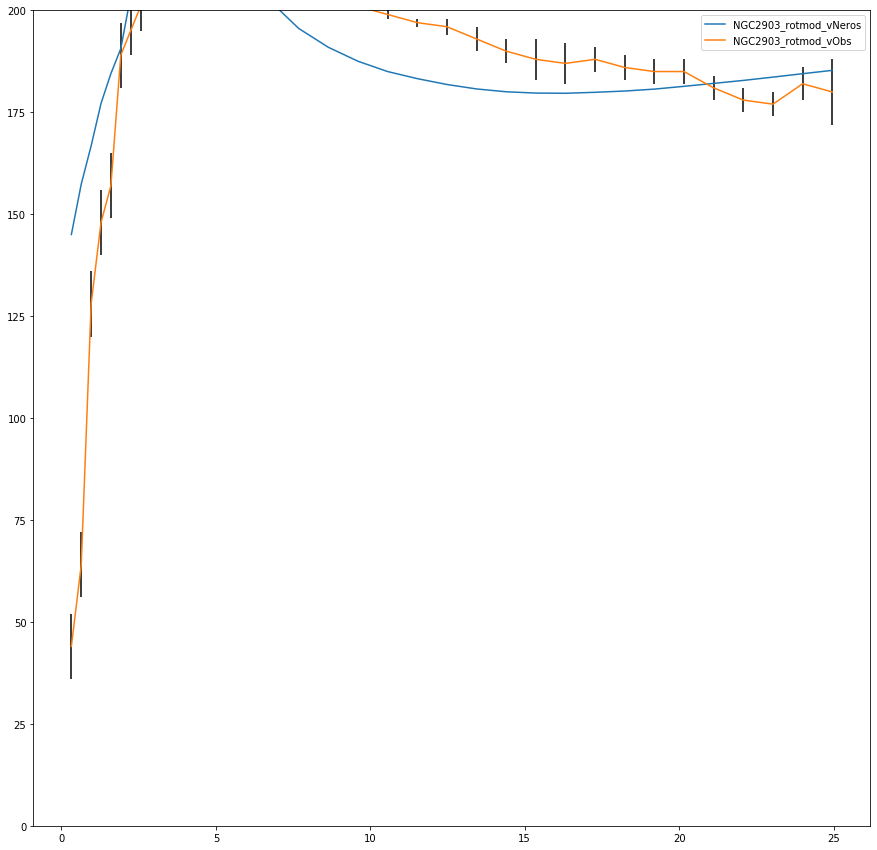

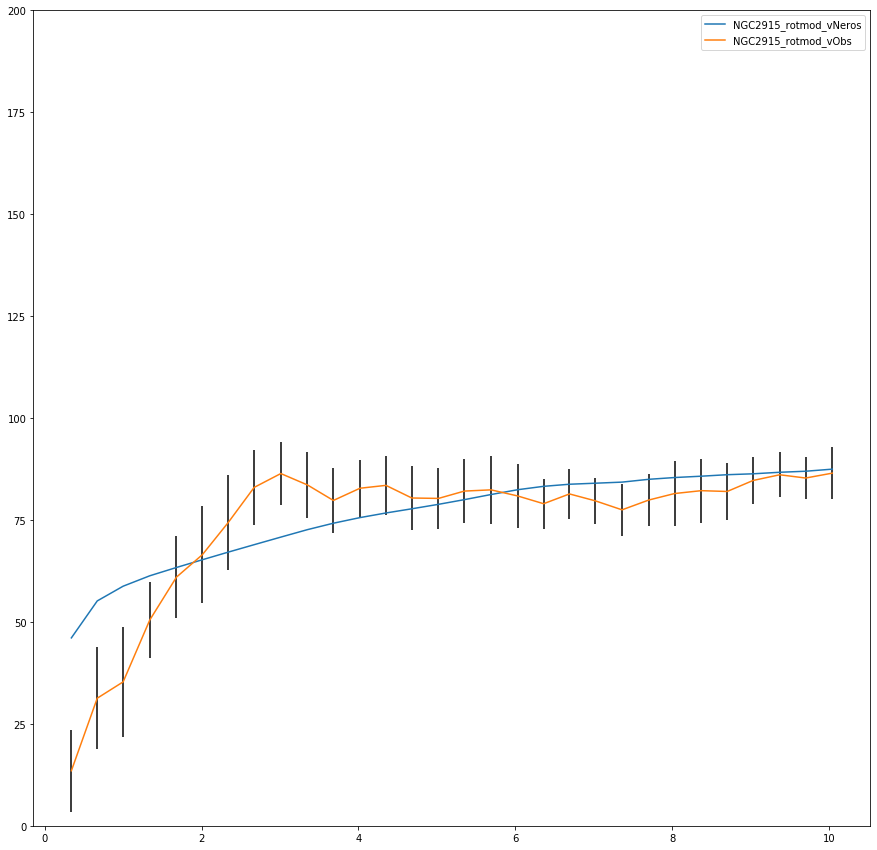

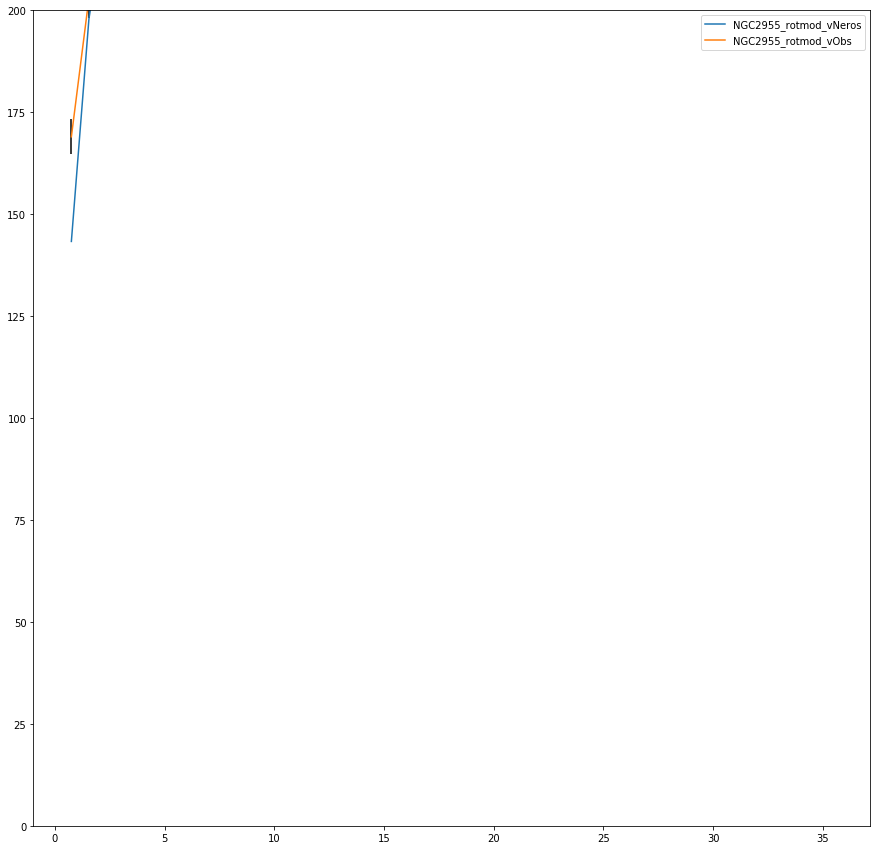

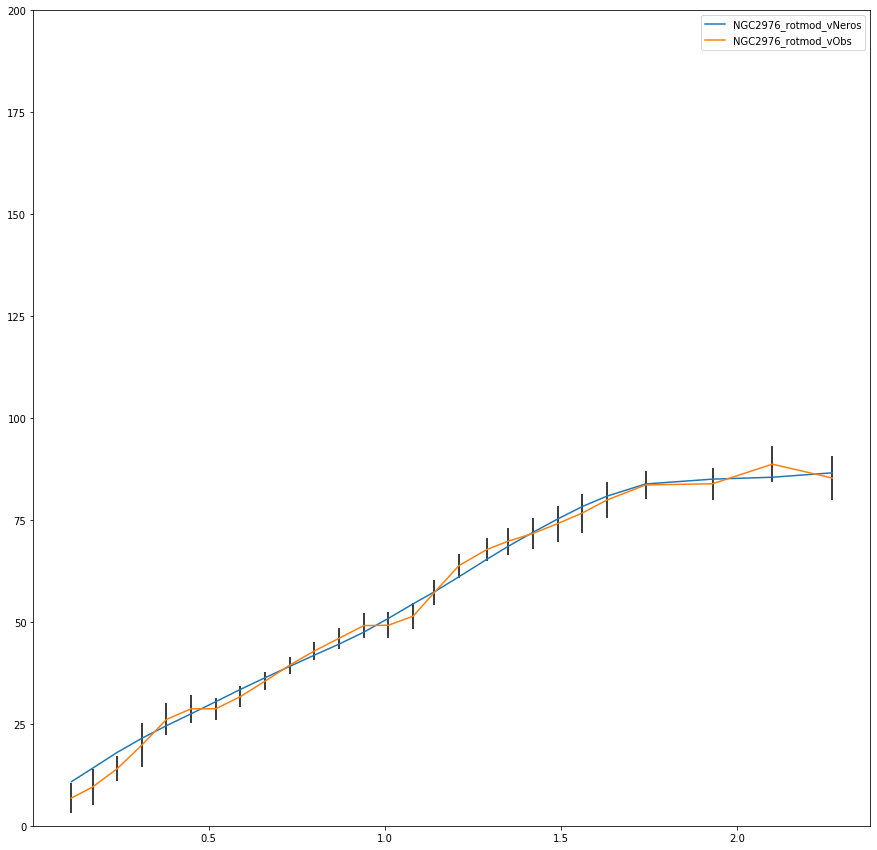

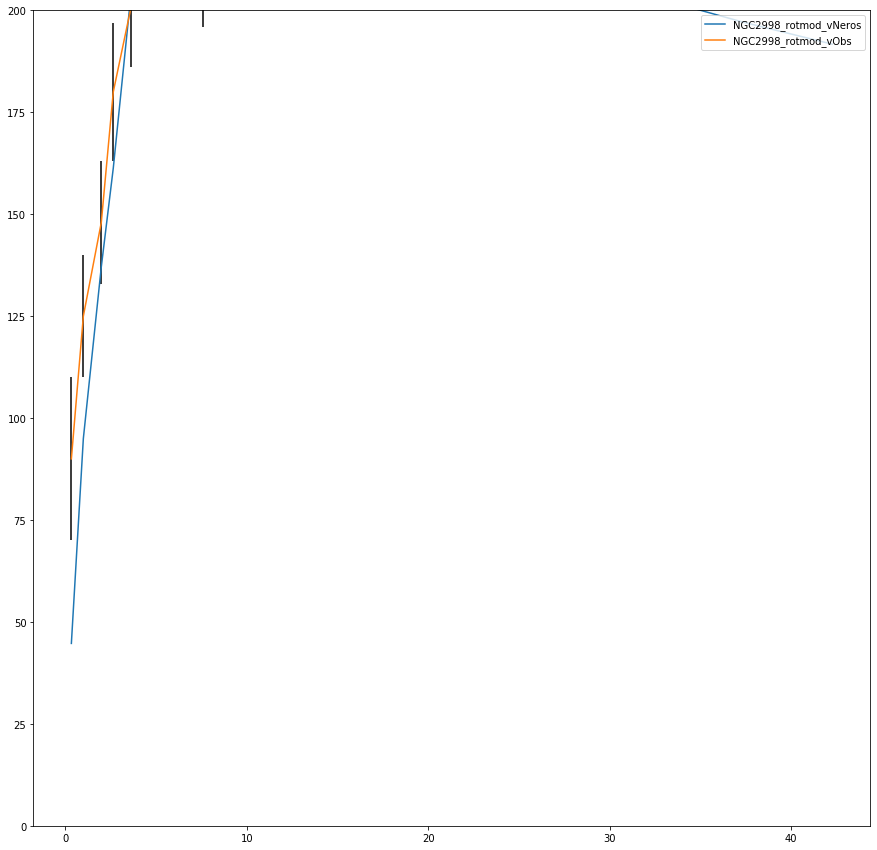

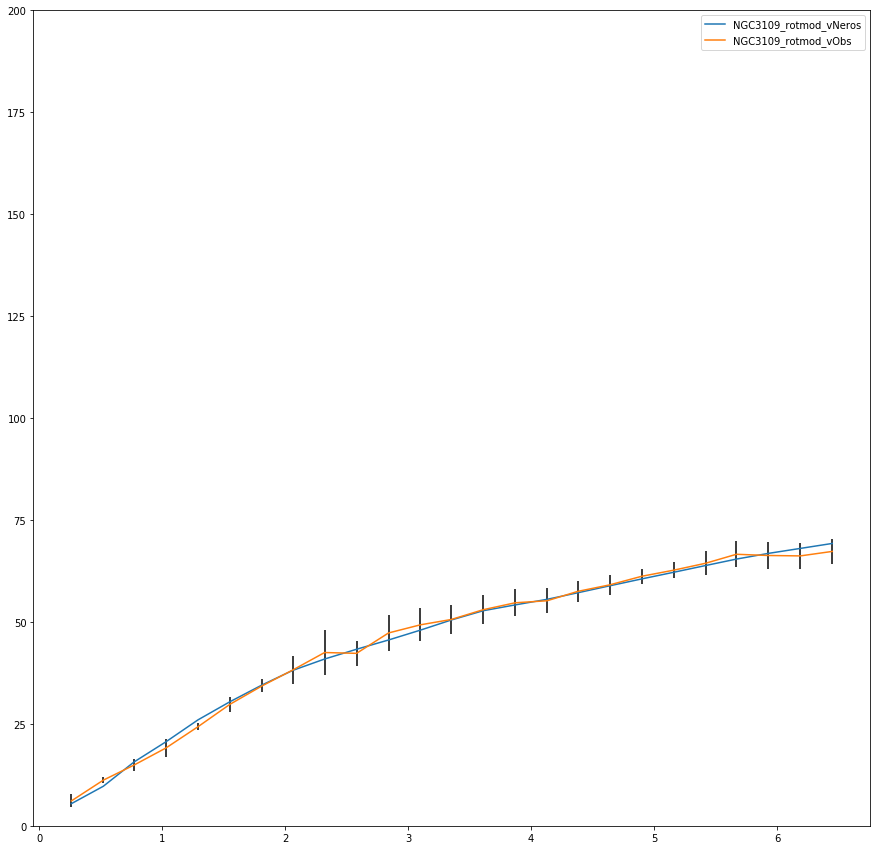

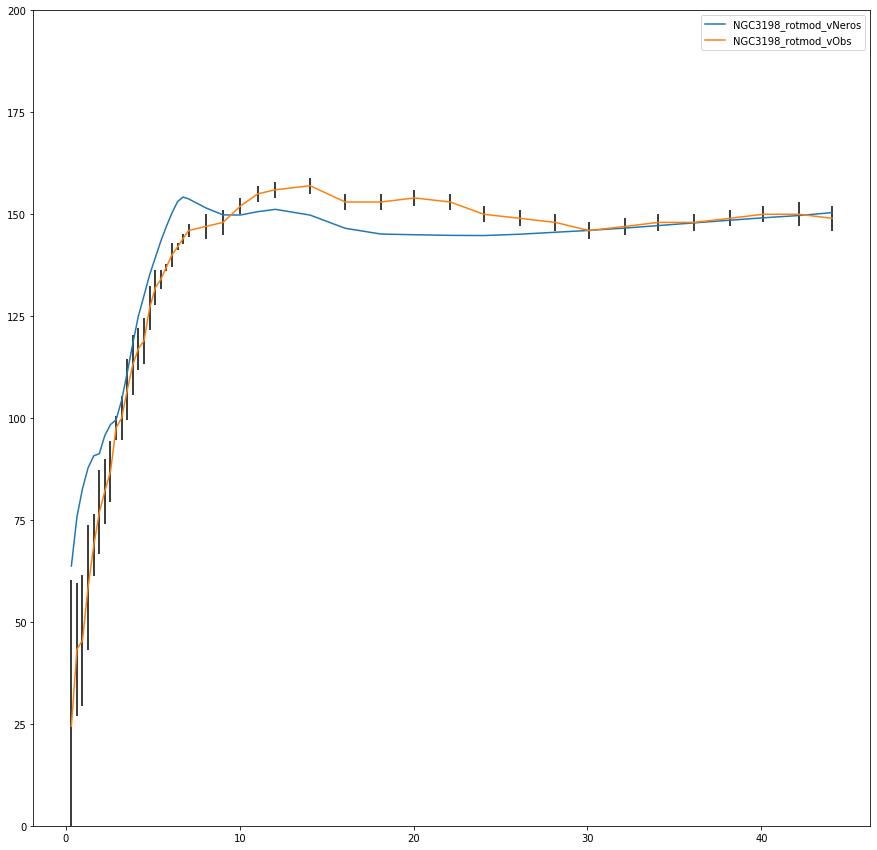

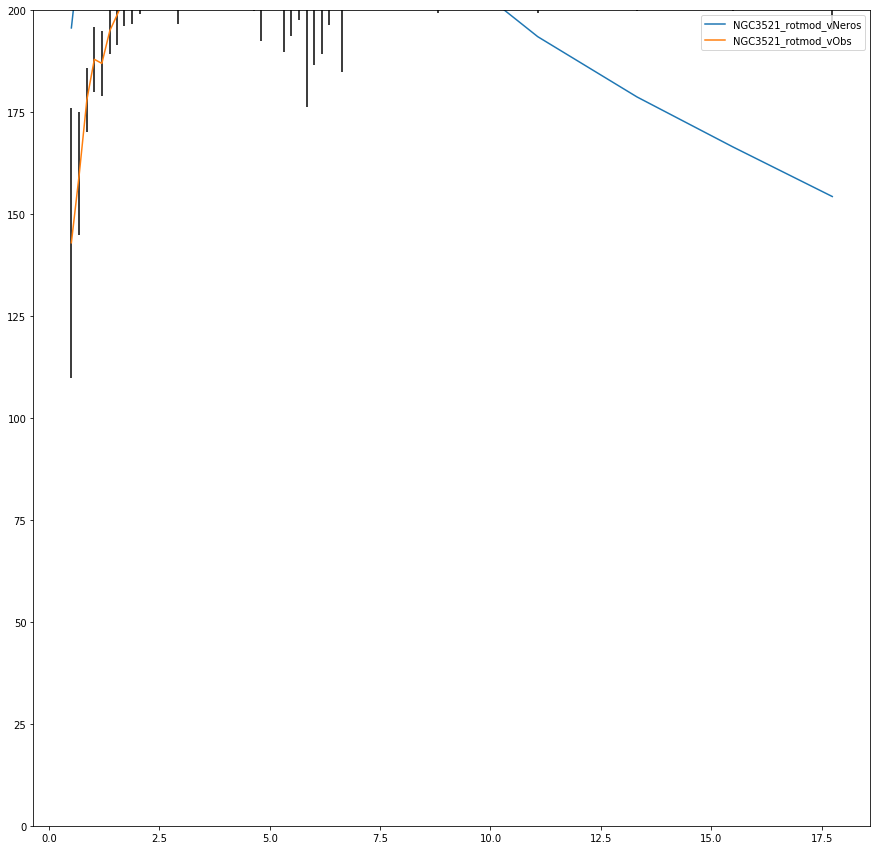

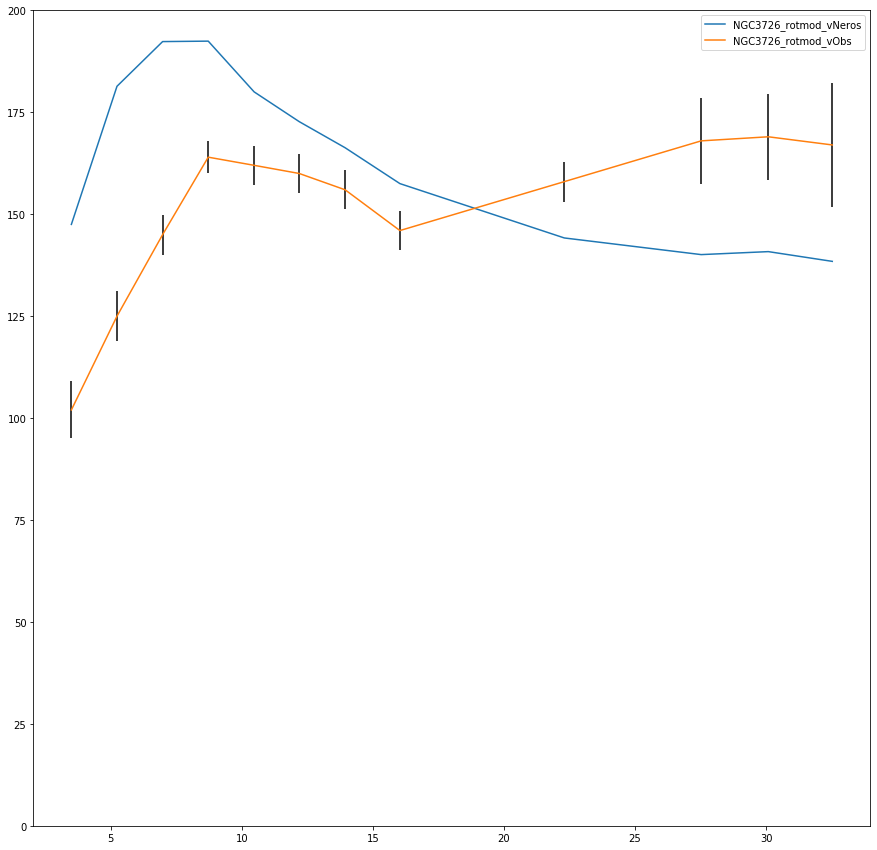

In [ ]:
out_file = "imported-data/data.csv"

#file = open(out_file, 'w')
#file.write('{0},{1},{2}\n'.format("Galaxy", "Alpha", "Beta"))

vLcmList = []


galaxyWeWant = "NGC2915_rotmod"

for galaxyName in sparcGalaxies:
    f, ax = plt.subplots(1, figsize = (15, 15))
    # change the name in "" to print only that galaxy
    #if (galaxyName != galaxyWeWant):
        #continue
    
    # data on this galaxy
    galaxy = np.array(sparcGalaxies[galaxyName])
    galaxy_rad = galaxy[:,0]
    galaxy_vObs = galaxy[:,1]
    galaxy_error = galaxy[:,2]
    galaxy_gas = galaxy[:,3]
    galaxy_disk = galaxy[:,4]
    galaxy_bulge = galaxy[:,5]
    galaxy_vLumSquared = Neros.vLumSquared(galaxy_gas, galaxy_disk, galaxy_bulge)
    galaxy_vLum = np.sqrt(galaxy_vLumSquared)
    
    # Make sure the arrays are matching lengths
    maxMWRad = MW_rad[len(MW_rad)-1]
    for i in range(len(galaxy_rad)):
        if galaxy_rad[i] > maxMWRad:
            galaxy_rad = galaxy_rad[:i]
            galaxy_vLum = galaxy_vLum[:i]
            galaxy_vObs = galaxy_vObs[:i]
            break
    
    # fitter
    vals, cov = curve_fit(simple,(galaxy_rad, galaxy_vLum),galaxy_vObs)
    fittedAlpha, fittedVLumFreeParam = vals

    
    # Run vLCM
    vLcm = Neros.vLcm(galaxy_rad, MW_vLum_interp_func(galaxy_rad), galaxy_vLum )
    vLcmList.append(vLcm)
    vNeros = simple((galaxy_rad, galaxy_vLum), fittedAlpha, fittedVLumFreeParam)
    ratio = vNeros/galaxy_vObs
    
    # printing to file
    chiSquare = chiSquared(galaxy_vObs, vNeros, galaxy_error)
    print(f"galaxyName is: {galaxyName}")
    
    print(f"chiSquare is: {chiSquare}")
    
    print(f"fittedAlpha is: {fittedAlpha}, \nfittedVLumFreeParam is: {fittedVLumFreeParam}")
    
    #print('{0},{1},{2},{3}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam, chiSquare))
    #file.write('{0},{1},{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))
    
    # This is Meagan's write statement
    with open(out_file, 'w') as f:
        f.write('{0},{1},{2}\n'.format("Galaxy", "Alpha", "Beta"))
        f.write('{0},{1},{2}\n'.format(galaxyName, fittedAlpha, fittedVLumFreeParam))
    f.close()
    
    
    # plot
    # scale of the plot
    ax.set_ylim(bottom = 0, top = 200)
    
    # plot vObs and vNeros
    ax.plot(galaxy_rad, vNeros, label="{}_vNeros".format(galaxyName))
    ax.plot(galaxy_rad, galaxy_vObs, label="{}_vObs".format(galaxyName))
    
    # error bar in vObs
    for i in range(len(galaxy_rad)):
        ax.vlines(galaxy_rad[i], galaxy_vObs[i] - galaxy_error[i], galaxy_vObs[i] + galaxy_error[i])
        
    ax.legend(loc="upper right")

    graph_file_name = "graphs/" + str(galaxyName)

    plt.savefig(graph_file_name)